# Multiecho fMRI Pilot Study: Acquisition and Denoising Effects

This Jupyter notebook analyzes a multiecho fMRI pilot dataset to evaluate the effects of acquisition parameters—headcoil type (20 vs. 64 channels), multiband (MB) factors (mb1, mb3, mb6), and multi-echo (ME) settings (me1, me4)—and denoising methods on data quality and functional metrics. It comprises four main sections:

1. **TSNR and Smoothness Analysis**: Assesses TSNR and Smoothness across acquisition types using mixed-effects models and bar plots, integrating Python and R for statistical rigor.
2. **Multiecho Analysis**: Examines a specified metric (e.g., beta) across ROIs, headcoils, and acquisitions, with bar plots and consistent statistical modeling.
3. **Framewsie Displacement and Denoising**: Links framewise displacement (fd_mean) to differences between Tedana and baseline denoising for me4 acquisitions, visualized with scatter plots split by headcoil and combined.
4. **Special Acquisitions**: Summarizes a metric for `sp` subjects across acquisitions, presented as a bar plot with means and errors.

### Objectives
- Quantify how acquisition parameters affect data quality (TSNR, Smoothness) and functional outcomes (e.g., beta values).
- Compare denoising strategies (Tedana vs. baseline) in relation to head motion (FD).
- Provide visual and statistical insights for pilot study optimization.

### Data Sources
- TSNR/Smoothness CSVs and fMRI text files from `~/Documents/GitHub/multiecho-pilot/derivatives/extractions`.
- FD data from a TSV file (`Outlier-info_mriqc-0.16.1.tsv`).

### Outputs
- CSV files with processed data, PNG plots (bar and scatter), and statistical summaries saved in the working directory.

This notebook supports reproducible analysis for understanding multiecho fMRI trade-offs, guiding future acquisition and preprocessing decisions.

Extraction script:
`https://github.com/DVS-Lab/multiecho-pilot/blob/main/code/extract_signal.sh`

# Figs 3 & 4. TSNR and Smoothness Analysis with Mixed-Effects Modeling

This code chunk processes and analyzes Temporal Signal-to-Noise Ratio (TSNR) and Smoothness data from multiecho fMRI acquisitions, evaluating the effects of headcoil type (20 vs. 64 channels), multiband (MB) factor (mb1, mb3, mb6), and multi-echo (ME) settings (me1, me4). It integrates Python for data handling and plotting with R for advanced statistical modeling, ensuring consistency with prior analyses.

### Key Components
1. **Data Loading and Preprocessing**:
   - `load_and_preprocess_data`: 
     - Loads TSNR data from a CSV file (e.g., `tsnr_path`) with columns like `Subject`, `ReceiveCoilName`, `AcquisitionType`, and `tsnrMedian`.
     - Loads Smoothness data from another CSV (e.g., `smoothness_path`), extracting `sub`, `acq`, and `smoothness` from file paths and values.
     - Merges datasets on `sub` and `acq`, excludes subjects with `sp` in IDs, and splits `acq` into `mb` and `me` columns.
     - Converts `coil`, `mb`, and `me` to categorical variables for analysis.

2. **Data Aggregation**:
   - `process_data`: 
     - Groups data by `mb`, `me`, and `coil`, calculating means, standard errors, and subject counts for a specified metric (`tsnrMedian` or `smoothness`).
     - Drops NaNs to ensure robust statistics.

3. **Visualization**:
   - `create_tsnr_smoothness_plots`: 
     - Generates bar plots for each headcoil type, showing metric values across MB factors (mb1, mb3, mb6), with ME settings differentiated by color (blue for me1, orange for me4).
     - Includes error bars (standard errors) and subject counts in titles.

4. **Statistical Analysis**:
   - `run_statistical_analysis`: 
     - Uses R’s `lme4` and `emmeans` via `rpy2` to fit a linear mixed-effects model: `<metric> ~ HC * MB * ME + (1 | Subj)`.
     - Treats `MB` and `ME` as ordered factors (`mb1 < mb3 < mb6`, `me1 < me4`) for linear and quadratic contrasts.
     - Computes pairwise comparisons for `MB` levels, averaged over `HC` and `ME`.
     - Outputs model summaries (random/fixed effects) and pairwise results.

5. **Execution**:
   - `analyze_multiecho_data`: 
     - Orchestrates the full pipeline: preprocessing, aggregation, plotting, and statistical analysis.
     - Returns a dictionary with merged data, plots, and statistical results.

### Inputs
- `tsnr_path`: Path to TSNR CSV file (e.g., `~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv`).
- `smoothness_path`: Path to Smoothness CSV file (e.g., `~/Documents/GitHub/multiecho-pilot/smoothness-all.csv`).

### Outputs
- **Data**: Merged DataFrame with columns `sub`, `coil`, `acq`, `tsnrMedian`, `smoothness`, `mb`, and `me`.
- **Plots**: Bar plots saved as `tsnrMedian_analysis.png` and `smoothness_analysis.png`.
- **Statistical Results**: Dictionary with model summaries and pairwise comparisons for TSNR and Smoothness.

### Notes
- Requires `rpy2` and R packages (`lme4`, `lmerTest`, `emmeans`) for statistical modeling.
- Handles missing data by dropping NaNs before analysis, with diagnostics printed for transparency.
- Plot aesthetics (e.g., font size=48) are standardized for readability.
- Assumes TSNR CSV has specific columns; raises errors if they’re missing.

This chunk provides a reproducible workflow for assessing TSNR and Smoothness across acquisition parameters, leveraging mixed-effects modeling to account for subject variability and interactions.

In [3]:
# TSNR and Smoothness with updated stats

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro

# Activate automatic conversion between pandas and R dataframes
pandas2ri.activate()

# Import R packages
lme4 = importr('lme4')
lmerTest = importr('lmerTest')
emmeans = importr('emmeans')
base = importr('base')

def load_and_preprocess_data(tsnr_path, smoothness_path):
    """
    Load and preprocess TSNR and smoothness data
    """
    tsnr_path = os.path.expanduser(tsnr_path)
    smoothness_path = os.path.expanduser(smoothness_path)
    
    data = pd.read_csv(tsnr_path)
    print("TSNR Data Columns:", list(data.columns))
    
    column_mapping = {
        'Subject': 'sub',
        'ReceiveCoilName': 'coil',
        'AcquisitionType': 'acq',
        'tsnrMedian': 'tsnrMedian'
    }
    
    missing_cols = [col for col in column_mapping.keys() if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}. Found columns: {list(data.columns)}")
    
    data = data.rename(columns=column_mapping)
    data = data[~data['sub'].str.contains('sp', na=False)]
    print("TSNR Data after preprocessing:")
    print(data.head())
    
    smooth_raw = pd.read_csv(smoothness_path)
    print("Smoothness CSV first few rows:")
    print(smooth_raw.head())
    print("Smoothness CSV columns:", list(smooth_raw.columns))
    
    smooth = pd.DataFrame()
    filepath_col = smooth_raw.columns[0]
    
    smooth['filepath'] = smooth_raw[filepath_col].where(
        smooth_raw[filepath_col].str.contains('sub-', na=False),
        pd.NA
    )
    smooth['filepath'] = smooth['filepath'].ffill()
    smooth['smoothness'] = pd.to_numeric(smooth_raw['Unnamed: 3'], errors='coerce')
    smooth = smooth.dropna(subset=['smoothness'])
    
    smooth['sub'] = smooth['filepath'].str.extract(r'sub-(\d+)')
    smooth['acq'] = smooth['filepath'].str.extract(r'acq-(mb\d+me\d+)')
    smooth = smooth[~smooth['sub'].str.contains('sp', na=False)]
    smooth = smooth[['sub', 'acq', 'smoothness']]
    print("Smoothness Data after preprocessing:")
    print(smooth.head())
    print("Smoothness Data shape:", smooth.shape)
    
    data_merged = pd.merge(data, smooth, on=['sub', 'acq'], how='left')
    data_merged['mb'] = data_merged['acq'].str.extract(r'(mb\d+)')[0]
    data_merged['me'] = data_merged['acq'].str.extract(r'(me\d+)')[0]
    
    categorical_cols = ['coil', 'mb', 'me']
    for col in categorical_cols:
        data_merged[col] = pd.Categorical(data_merged[col])
    
    print("Merged Data Columns:", list(data_merged.columns))
    print("Merged Data Head:")
    print(data_merged.head())
    print("Merged Data Info:")
    print(data_merged.info())
    
    return data_merged

def process_data(data, value_column):
    """
    Calculate mean and standard error by multiband, multi-echo, and coil
    """
    data = data.dropna(subset=['mb', 'me', 'coil', value_column])
    
    print(f"Data after dropna for {value_column}:")
    print(data.head())
    print(f"Number of rows: {len(data)}")
    
    agg_data = data.groupby(['mb', 'me', 'coil'], observed=True).agg({
        value_column: 'mean',
        'sub': 'nunique'
    }).reset_index()
    
    std_error = data.groupby(['mb', 'me', 'coil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index()
    std_error.columns = ['mb', 'me', 'coil', 'se']
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'coil'])
    result.columns = ['mb', 'me', 'coil', value_column, 'n_subjects', 'se']
    
    print(f"Processed Data for {value_column}:")
    print(result.head())
    print(f"Processed Data Info:")
    print(result.info())
    
    return result

def create_tsnr_smoothness_plots(data_processed, img_type='tsnr', save_files=True):
    """
    Create plots similar to the original Python kernel's bar plots
    """
    plt.rcParams.update({'font.size': 48})
    coil_types = data_processed['coil'].unique()
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    if len(coil_types) == 1:
        axes = [axes]
    
    width = 0.4
    x1 = [0, 1.2, 2.4]
    x2 = [x + width for x in x1]
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    mb_levels = ['mb1', 'mb3', 'mb6']
    
    all_y_values = []
    all_y_errors = []
    
    for i, (coil, ax) in enumerate(zip(coil_types, axes)):
        coil_data = data_processed[data_processed['coil'] == coil]
        if coil_data.empty:
            print(f"No data for coil {coil}")
            ax.set_title(f"{coil}-Channel\nn=0", fontsize=48, fontweight='bold')
            continue
        
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        y_values = list(me1_means) + list(me4_means)
        y_errors = list(me1_errors) + list(me4_errors)
        all_y_values.extend([v for v in y_values if v != 0])
        all_y_errors.extend([e for e in y_errors if e != 0])
        
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(mb_levels, fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        
        if i == 0:
            ax.set_ylabel(img_type.upper(), fontsize=48)
        
        n_subjects = int(coil_data['n_subjects'].iloc[0]) if not coil_data['n_subjects'].empty else 0
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        y_max = max([v + e for v, e in zip(y_values, y_errors) if v != 0], default=0)
        margin = y_max * 0.1
        ax.set_ylim(0, y_max + margin)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    
    if save_files:
        plt.savefig(f'{img_type}_analysis.png', dpi=300, bbox_inches='tight')
    
    return fig

def run_statistical_analysis(data):
    """
    Perform statistical analysis using R's lme4 and emmeans
    """
    # Prepare data for R: rename columns to match R script and drop NaN
    data_r = data.rename(columns={'sub': 'Subj', 'coil': 'HC', 'mb': 'MB', 'me': 'ME', 
                                  'tsnrMedian': 'TSNR', 'smoothness': 'Smoothness'})
    data_r = data_r.dropna(subset=['TSNR', 'Smoothness', 'MB', 'ME', 'HC', 'Subj'])
    
    # Define factor levels to match AFNI contrasts
    data_r['Subj'] = pd.Categorical(data_r['Subj'])
    data_r['MB'] = pd.Categorical(data_r['MB'], categories=['mb1', 'mb3', 'mb6'], ordered=True)
    data_r['ME'] = pd.Categorical(data_r['ME'], categories=['me1', 'me4'], ordered=True)
    data_r['HC'] = pd.Categorical(data_r['HC'])  # '20', '64' as categories
    
    # Convert to R dataframe
    r_df = pandas2ri.py2rpy(data_r)
    
    results = {}
    for metric in ['TSNR', 'Smoothness']:
        # Define the formula for the mixed-effects model
        formula = Formula(f'{metric} ~ HC * MB * ME + (1 | Subj)')
        
        # Fit the model using lmer
        model = lme4.lmer(formula, data=r_df)
        
        # Get the model summary
        summary = base.summary(model)
        print(f"\nLinear Mixed Effects Model for {metric}:")
        print(summary)
        
        # Pairwise comparisons using emmeans
        emm = emmeans.emmeans(model, 'MB')
        pairwise = ro.r('pairs')(emm)  # Explicitly call R's pairs() function
        print(f"\nPairwise comparisons for MB in {metric}:")
        print(pairwise)
        
        results[metric] = {
            'model_summary': str(summary),
            'pairwise_MB': str(pairwise)
        }
    
    return results

def analyze_multiecho_data(tsnr_path, smoothness_path):
    """
    Main function to perform complete analysis
    """
    data_merged = load_and_preprocess_data(tsnr_path, smoothness_path)
    tsnr_processed = process_data(data_merged, 'tsnrMedian')
    smoothness_processed = process_data(data_merged, 'smoothness')
    
    tsnr_plot = create_tsnr_smoothness_plots(tsnr_processed, 'tsnrMedian')
    smoothness_plot = create_tsnr_smoothness_plots(smoothness_processed, 'smoothness')
    
    statistical_results = run_statistical_analysis(data_merged)
    
    return {
        'data': data_merged,
        'tsnr_plot': tsnr_plot,
        'smoothness_plot': smoothness_plot,
        'statistical_results': statistical_results
    }

# Example usage (uncomment and adjust paths as needed):
# result = analyze_multiecho_data('path/to/tsnr.csv', 'path/to/smoothness.csv')

TSNR Data Columns: ['Subject', 'ReceiveCoilName', 'AcquisitionType', 'tsnrMean', 'tsnrMedian']
TSNR Data after preprocessing:
     sub  coil     acq   tsnrMean  tsnrMedian
0  10015    64  mb1me1  52.093262   47.814824
1  10015    64  mb3me1  57.683910   52.642603
2  10015    64  mb6me1  58.677708   53.953856
3  10017    64  mb1me1  39.583363   37.468284
4  10017    64  mb1me4  56.804039   51.711247
Smoothness CSV first few rows:
  sub-10015/L1_task-sharedreward_model-1_type-act_acq-mb1me1_sm-5_denoising-base_EstimateSmoothing.feat/smoothness-5mm.txt  \
0                                           0.959011                                                                         
1  sub-10015/L1_task-sharedreward_model-1_type-ac...                                                                         
2                                           0.952358                                                                         
3  sub-10015/L1_task-sharedreward_model-1_type-ac...           

/opt/anaconda3/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "HC". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '



Linear Mixed Effects Model for TSNR:
Linear mixed model fit by REML ['lmerMod']
Formula: TSNR ~ HC * MB * ME + (1 | Subj)
   Data: structure(list(Subj = structure(c(1L, 1L, 2L, 2L, 2L, 2L, 2L,  
2L, 3L, 3L, 3L, 3L, 3L, 3L, 4L, 4L, 4L, 4L, 5L, 5L, 5L, 5L, 5L,  
5L, 6L, 6L, 6L, 6L, 6L, 6L, 7L, 7L, 7L, 7L, 7L, 7L, 8L, 8L, 8L,  
8L, 8L, 8L, 9L, 9L, 9L, 9L, 9L, 9L, 10L, 10L, 10L, 10L, 10L,  
10L, 11L, 11L, 11L, 11L, 11L, 11L, 12L, 12L, 12L, 12L, 12L, 12L,  
13L, 13L, 13L, 13L, 13L, 13L, 14L, 14L, 14L, 14L, 14L, 14L, 15L,  
15L, 15L, 15L, 15L, 15L, 16L, 16L, 16L, 16L, 16L, 16L, 17L, 17L,  
17L, 17L, 17L, 17L, 18L, 18L, 18L, 18L, 18L, 18L, 19L, 19L, 19L,  
19L, 19L, 19L, 20L, 20L, 20L, 20L, 20L, 20L, 21L, 21L, 21L, 21L,  
21L, 21L, 22L, 22L, 22L, 22L, 22L, 22L, 23L, 23L, 23L, 23L, 23L,  
23L, 24L, 24L, 24L, 24L, 24L, 24L, 25L, 25L, 25L, 25L, 25L, 25L,  
26L, 26L, 26L, 26L, 26L, 26L, 27L, 27L, 27L, 27L, 27L, 27L, 28L,  
28L, 28L, 28L, 28L, 29L, 29L, 29L, 29L, 29L, 29L, 30L, 30L, 30L,  
30L, 3

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: NOTE: Results may be misleading due to involvement in interactions




Pairwise comparisons for MB in TSNR:
 contrast  estimate    SE  df t.ratio p.value
 mb1 - mb3     2.53 0.431 212   5.864  <.0001
 mb1 - mb6     7.63 0.429 212  17.780  <.0001
 mb3 - mb6     5.10 0.427 212  11.946  <.0001

Results are averaged over the levels of: HC, ME 
Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 3 estimates 


Linear Mixed Effects Model for Smoothness:
Linear mixed model fit by REML ['lmerMod']
Formula: Smoothness ~ HC * MB * ME + (1 | Subj)
   Data: structure(list(Subj = structure(c(1L, 1L, 2L, 2L, 2L, 2L, 2L,  
2L, 3L, 3L, 3L, 3L, 3L, 3L, 4L, 4L, 4L, 4L, 5L, 5L, 5L, 5L, 5L,  
5L, 6L, 6L, 6L, 6L, 6L, 6L, 7L, 7L, 7L, 7L, 7L, 7L, 8L, 8L, 8L,  
8L, 8L, 8L, 9L, 9L, 9L, 9L, 9L, 9L, 10L, 10L, 10L, 10L, 10L,  
10L, 11L, 11L, 11L, 11L, 11L, 11L, 12L, 12L, 12L, 12L, 12L, 12L,  
13L, 13L, 13L, 13L, 13L, 13L, 14L, 14L, 14L, 14L, 14L, 14L, 15L,  
15L, 15L, 15L, 15L, 15L, 16L, 16L, 16L, 16L, 16L, 16L, 17L, 17L,  
17L, 17L,

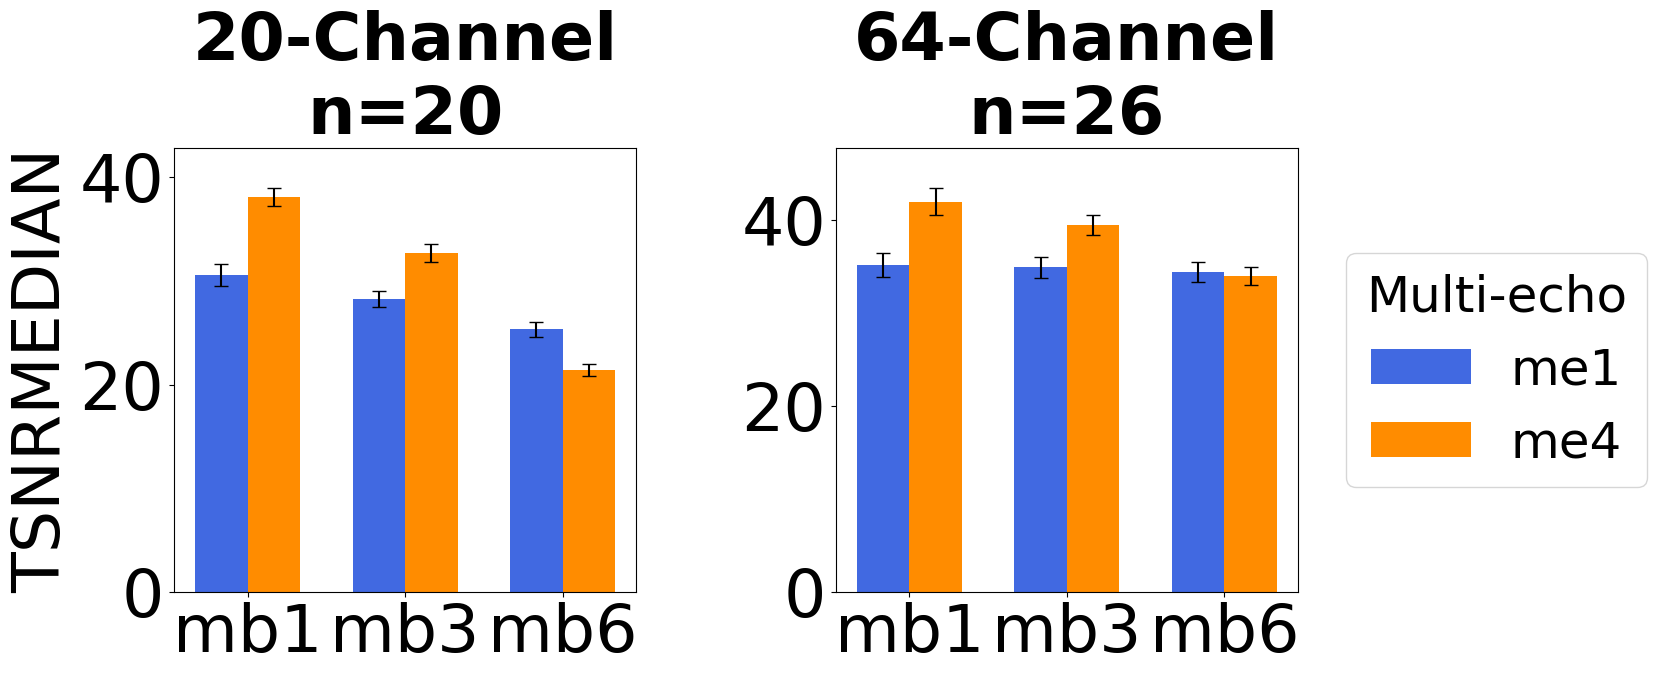

In [4]:
results = analyze_multiecho_data(
    '~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv', 
    '~/Documents/GitHub/multiecho-pilot/smoothness-all.csv'
)

# Figs 5-7. Analysis of Multiecho fMRI Data with Mixed-Effects Modeling

This code chunk defines a set of Python functions to process, analyze, and visualize multiecho fMRI data extracted from text files, focusing on the effects of headcoil type (20 vs. 64 channels), multiband (MB) factor (mb1, mb3, mb6), and multi-echo (ME) settings (me1, me4) on a specified imaging metric (e.g., beta values). The analysis mirrors a prior TSNR/Smoothness study, ensuring consistency in statistical methodology.

### Key Components
1. **Data Extraction and Preparation**:
   - `extract_file_data`: Parses text files in a specified directory (e.g., `~/Documents/GitHub/multiecho-pilot/derivatives/extractions`) matching a regex pattern, extracting metric values for each subject and acquisition type (e.g., `mb1me1`, `mb3me4`).
   - `create_dataframe`: Builds a wide-format DataFrame with subjects, headcoil assignments (20 or 64, based on a predefined list), and acquisition-specific metric values.

2. **Visualization**:
   - `prepare_plot_data`: Computes means and standard errors of the metric for each acquisition, split by headcoil.
   - `create_bar_plots`: Generates side-by-side bar plots (20-channel vs. 64-channel) showing the metric across MB factors, with ME settings differentiated by color (blue for me1, orange for me4).

3. **Statistical Analysis**:
   - `process_mask`: Orchestrates the workflow for a given mask (e.g., `VSconstrained`):
     - Reshapes data into long format with `mb` (multiband) and `me` (multi-echo) as separate columns.
     - Treats `mb` and `me` as ordered categorical variables (`mb1 < mb3 < mb6`, `me1 < me4`) to enable linear (`.L`) and quadratic (`.Q`) contrasts.
     - Fits a linear mixed-effects model: `<metric> ~ headcoil * mb * me + (1 | subject)`, capturing main effects and interactions with a random intercept for subjects.
     - Performs pairwise Tukey HSD tests for `mb` levels, averaged over `headcoil` and `me`, to assess differences (e.g., mb1 vs. mb3).
   - Outputs include model summaries (fixed/random effects) and pairwise comparison results.

4. **Execution**:
   - `run_analysis`: Runs the full pipeline across multiple masks, with options to save DataFrames and plots as CSV and PNG files.

### Inputs
- `base_dir`: Directory containing fMRI data files (default: `~/Documents/GitHub/multiecho-pilot/derivatives/extractions`).
- `type_value`: Analysis type (e.g., `act` for activation).
- `img_value`: Metric to analyze (e.g., `beta`).
- `mask_values`: List of ROIs (e.g., `["VSconstrained", "rFFA"]`).
- `denoise_value`: Denoising method (e.g., `smooth`).
- `headcoil_64_subjects`: List of subject IDs using the 64-channel headcoil.

### Outputs
- **DataFrames**: Saved as CSV files (e.g., `multiecho_data_act_beta_VSconstrained_smooth_RewgtPun.csv`).
- **Plots**: Bar plots saved as PNG files (e.g., `multiecho_plots_act_beta_VSconstrained_smooth_RewgtPun.png`).
- **Statistical Results**: Printed summaries of mixed-effects models and pairwise comparisons for each mask.

### Notes
- The code assumes text files contain a single float value per file and skips files with `sp` in the subject ID.
- Missing data is handled by dropping NaNs before modeling, with diagnostics printed for debugging.
- Plot aesthetics (e.g., font size, colors) are set via `initialize_plotting_engine` for consistency.

This chunk establishes a reproducible framework for comparing acquisition parameters across ROIs, aligning statistical rigor with the TSNR/Smoothness analysis.

In [54]:
# Define functions for generating plots and statistical analysis

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def initialize_plotting_engine():
    """Initialize the plotting environment with required settings"""
    sns.set_style("whitegrid")
    sns.set_context("talk")
    plt.rcParams.update({'font.size': 56})

def determine_contrast(mask_value):
    """Determine contrast based on mask value"""
    if mask_value in ["VSconstrained", "VMPFC"]:
        return "Rew>Pun"
    elif mask_value == "rFFA":
        return "Str>Com"
    elif mask_value in ["bilateralMotor", "bilateralCerebellum"]:
        return "Avg (L>R, R>L)"
    else:
        return "Unknown"

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in headcoil_64_subjects else 20)
    df['headcoil'] = df['headcoil'].astype(str)  # Convert headcoil to categorical
    column_order = ['subject', 'headcoil'] + acq_params
    df = df[column_order]
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    return df

def prepare_plot_data(df):
    """Prepare data for plotting by calculating means and errors by headcoil type"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    df_20 = df[df['headcoil'] == '20']
    df_64 = df[df['headcoil'] == '64']
    results = {}
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        means = {acq: hc_df[acq].mean() for acq in acq_params}  # NaN-safe by default
        errors = {acq: hc_df[acq].sem() for acq in acq_params}  # NaN-safe by default
        results[hc_name] = {'means': means, 'errors': errors, 'count': len(hc_df)}
    return results

def create_bar_plots(plot_data, mask_value, contrast, is_first=False, is_last=False):
    """Create bar plots for the given data with consistent y-axis limits within each ROI"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    width = 0.4
    x1 = [0, 1.2, 2.4]
    x2 = [0+width, 1.2+width, 2.4+width]
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    all_y_values = []
    all_y_errors = []
    
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        all_y_values.extend([v for v in y_values if not np.isnan(v)])  # Filter NaNs
        all_y_errors.extend([e for e in y_errors if not np.isnan(e)])  # Filter NaNs
        if i == 0:
            ax.set_ylabel(f"{mask_value}", fontsize=56)
        if is_first:
            ax.set_title(f"{title}\nn={count}", fontsize=56, fontweight='bold')
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=56)
        ax.tick_params(axis='both', which='major', labelsize=56)
        if is_first and i == 1:
            legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=112)
            legend.get_title().set_fontsize(112)
            ax.legend(loc='upper right')
    
    if all_y_values and all_y_errors:
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1
        ax1.set_ylim(y_min - margin, y_max + margin)
        ax2.set_ylim(y_min - margin, y_max + margin)
    else:
        print(f"Warning: No valid data for plotting y-limits in {mask_value}")
    
    if is_last:
        fig.text(0.5, -0.05, 'Multiband Factor', ha='center', fontsize=56)
    plt.tight_layout(pad=1.0)
    if is_last:
        plt.subplots_adjust(bottom=0.2)
    return fig

def process_mask(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects, 
                 is_first=False, is_last=False, save_files=True, output_dir="../derivatives/plots"):
    """Process a single mask, create plots, and run statistical analysis with post-hoc tests"""
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    contrast = determine_contrast(mask_value)
    print(f"\nProcessing files with parameters: type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}")
    print(f"Using contrast: {contrast}")
    
    # Extract data
    data_by_subject = extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value)
    if not data_by_subject:
        print(f"No matching files found for mask: {mask_value}")
        return None
    
    # Create DataFrame
    df = create_dataframe(data_by_subject, headcoil_64_subjects)
    
    if save_files:
        output_file = os.path.join(output_dir, f"multiecho_data_{type_value}_{img_value}_{mask_value}_{denoise_value}_{contrast.replace('>', 'gt').replace(' ', '_').replace(',', '')}.csv")
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    print(f"Found data for {len(df)} subjects")
    print("\nSample of the data:")
    print(df.head())
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get('64', 0)}")
    print(f"20-channel: {headcoil_counts.get('20', 0)}")
    print(f"Missing values per column:\n{df.isnull().sum()}")  # Added diagnostic
    
    # Reshape data for statistical analysis
    df_long = pd.melt(
        df, 
        id_vars=['subject', 'headcoil'], 
        value_vars=['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4'],
        var_name='acq', 
        value_name=img_value
    )
    df_long['mb'] = df_long['acq'].str[:3]  # Extract 'mb1', 'mb3', 'mb6'
    df_long['me'] = df_long['acq'].str[3:]  # Extract 'me1', 'me4'
    df_long = df_long.drop(columns=['acq'])
    
    # Set ordered factors for mb and me (like MB.L, MB.Q, ME.L)
    df_long['mb'] = pd.Categorical(df_long['mb'], categories=['mb1', 'mb3', 'mb6'], ordered=True)
    df_long['me'] = pd.Categorical(df_long['me'], categories=['me1', 'me4'], ordered=True)
    df_long['headcoil'] = df_long['headcoil'].astype(str)  # Ensure headcoil is categorical
    
    # Run linear mixed-effects model with NaN handling
    print(f"\nRunning statistical analysis for {mask_value} ({img_value})...")
    df_long_clean = df_long.dropna(subset=[img_value])  # Drop NaNs before LMM
    if len(df_long_clean) < 2:  # Minimum observations for LMM
        print(f"Insufficient data for LMM after removing NaNs: {len(df_long_clean)} observations")
        result = None
    else:
        try:
            model = smf.mixedlm(f"{img_value} ~ headcoil * mb * me", df_long_clean, groups=df_long_clean["subject"])
            result = model.fit()
            print(result.summary())
            
            # Pairwise comparisons for mb (averaged over headcoil and me)
            print(f"\nPairwise comparisons for mb (averaged over headcoil and me):")
            tukey_mb = pairwise_tukeyhsd(endog=df_long_clean[img_value], groups=df_long_clean['mb'], alpha=0.05)
            print(tukey_mb)
            
        except Exception as e:
            print(f"LMM failed: {e}")
            print(f"Shape of df_long_clean: {df_long_clean.shape}")
            print(f"Missing values in df_long_clean:\n{df_long_clean.isnull().sum()}")
            result = None
    
    # Prepare plot data and create plots regardless of LMM success
    plot_data = prepare_plot_data(df)
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data, mask_value, contrast, is_first, is_last)
    
    if save_files:
        plot_file = os.path.join(output_dir, f"multiecho_plots_{type_value}_{img_value}_{mask_value}_{denoise_value}_{contrast.replace('>', 'gt').replace(' ', '_').replace(',', '')}.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as '{plot_file}'")
    
    return {
        'dataframe': df,
        'figure': fig,
        'contrast': contrast,
        'plot_data': plot_data,
        'lmm_result': result
    }

def run_analysis(type_value, img_value, mask_values, denoise_value, base_dir=None, save_files=True, output_dir="../derivatives/plots"):
    """Run the full analysis for the given parameters"""
    if base_dir is None:
        base_dir = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    headcoil_64_subjects = [
        "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
        "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
        "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
        "10186", "10188", "10221"
    ]
    initialize_plotting_engine()
    print(f"\nAnalysis Parameters: TYPE_VALUE={type_value.upper()}, IMG_VALUE={img_value.capitalize()}")
    results = {}
    for i, mask_value in enumerate(mask_values):
        is_first = (i == 0)
        is_last = (i == len(mask_values) - 1)
        result = process_mask(
            base_dir=base_dir,
            type_value=type_value,
            img_value=img_value, 
            mask_value=mask_value,
            denoise_value=denoise_value,
            headcoil_64_subjects=headcoil_64_subjects,
            is_first=is_first,
            is_last=is_last,
            save_files=save_files,
            output_dir=output_dir
        )
        if result:
            results[mask_value] = result
    return results


Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Tsnr

Processing files with parameters: type=act, img=tsnr, mask=VSconstrained, denoise=base
Using contrast: Rew>Pun
Data saved to ../derivatives/plots/multiecho_data_act_tsnr_VSconstrained_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil     mb1me1     mb3me1     mb6me1     mb1me4     mb3me4  \
15    10017       64  47.441217  48.736170  43.101251  70.091718  58.504754   
16    10024       64  41.595123  53.181006  51.031723  64.281742  60.599686   
7     10035       64  51.308512  46.870595  38.905418  72.807299  63.647671   
22    10041       64  44.525315  38.940282  39.330609  51.993155  45.745058   
0     10043       64  56.283196  52.007653  51.011447  59.484562  54.419625   

       mb6me4  
15  42.642998  
16  45.972115  
7   46.401998  
22  43.801459  
0   41.067986  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1  

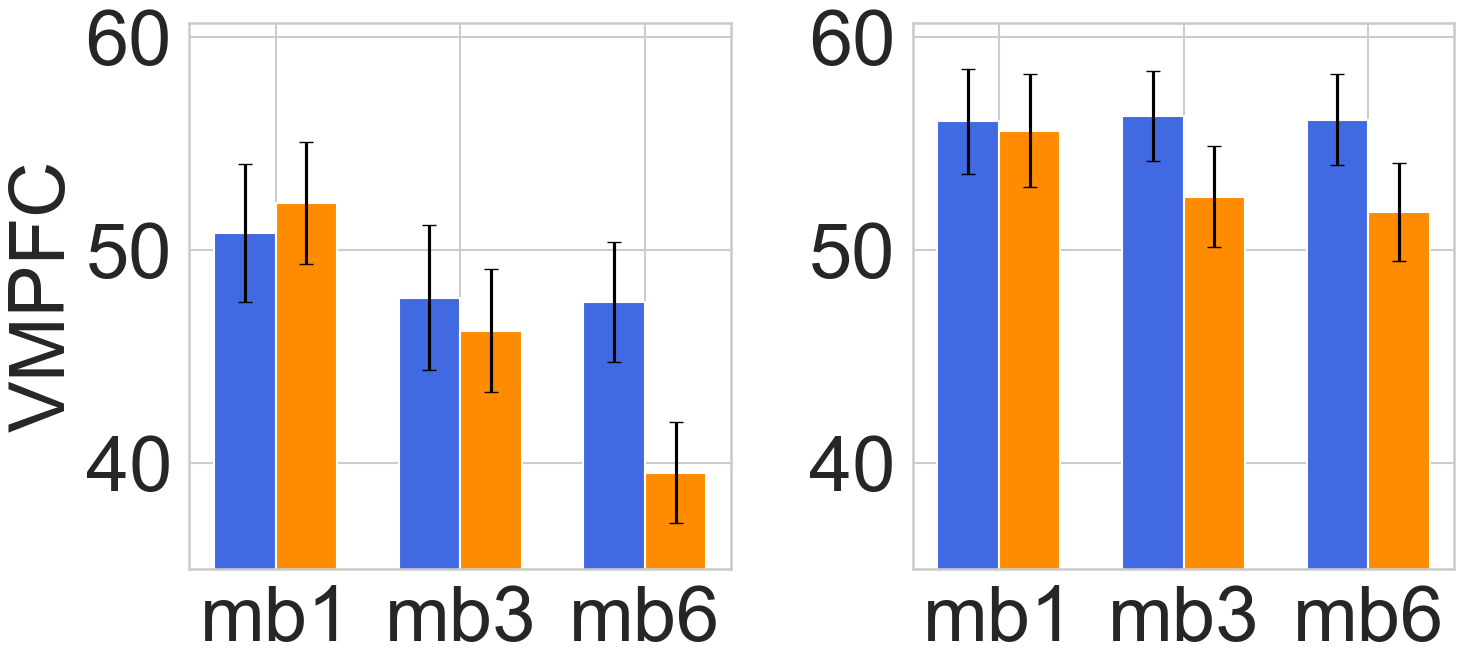

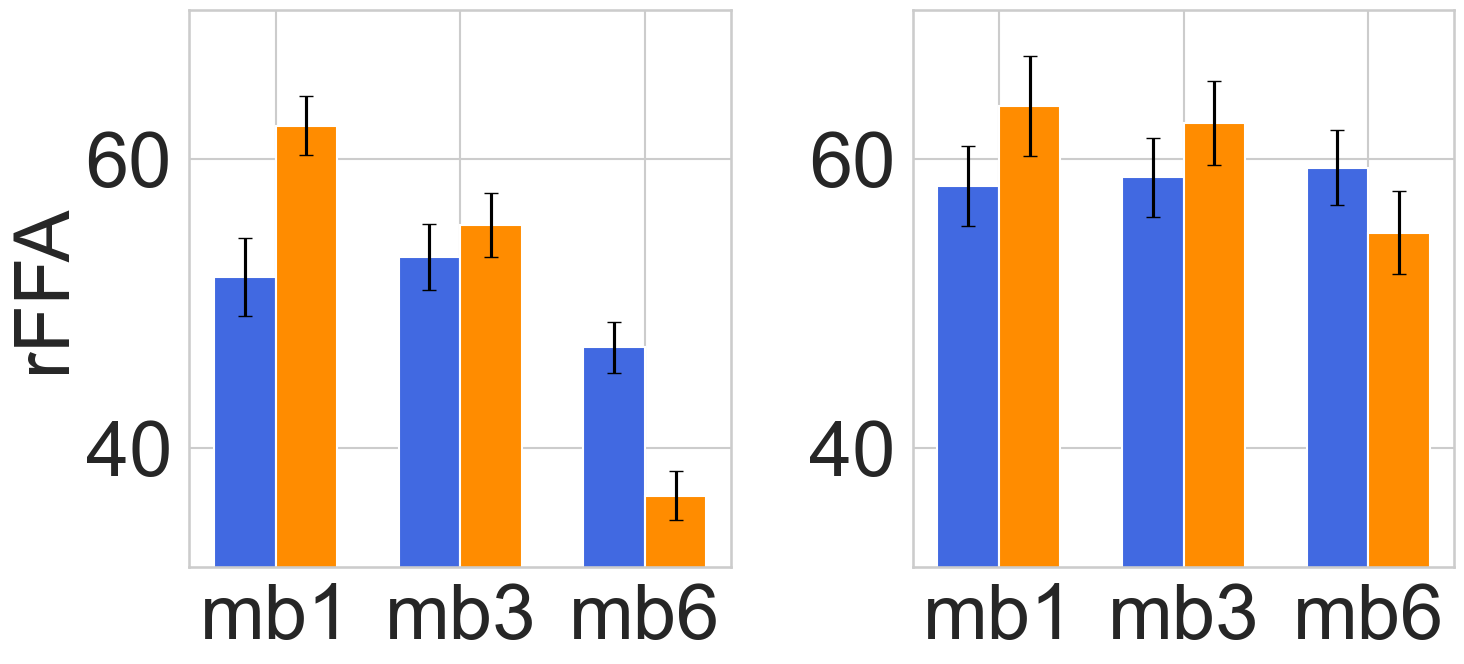

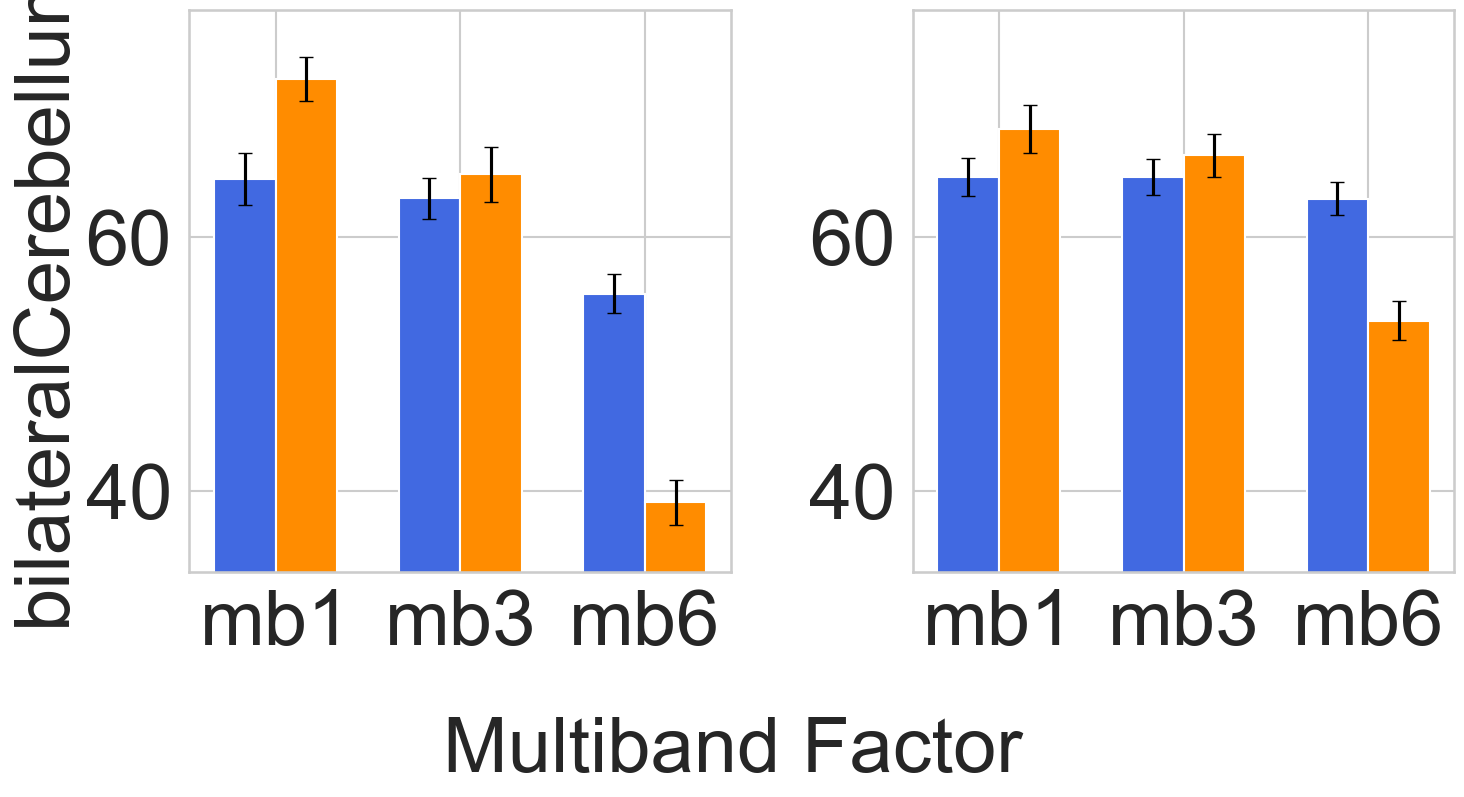

In [56]:
# Figure 5. TSNR for each acquisition in each ROI
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "tsnr" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Tsnr

Processing files with parameters: type=act, img=tsnr, mask=VSconstrained, denoise=base
Using contrast: Rew>Pun
Data saved to multiecho_data_act_tsnr_VSconstrained_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil     mb1me1     mb3me1     mb6me1     mb1me4     mb3me4  \
15    10017       64  47.441217  48.736170  43.101251  70.091718  58.504754   
16    10024       64  41.595123  53.181006  51.031723  64.281742  60.599686   
7     10035       64  51.308512  46.870595  38.905418  72.807299  63.647671   
22    10041       64  44.525315  38.940282  39.330609  51.993155  45.745058   
0     10043       64  56.283196  52.007653  51.011447  59.484562  54.419625   

       mb6me4  
15  42.642998  
16  45.972115  
7   46.401998  
22  43.801459  
0   41.067986  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1      0
mb6me1      0
m

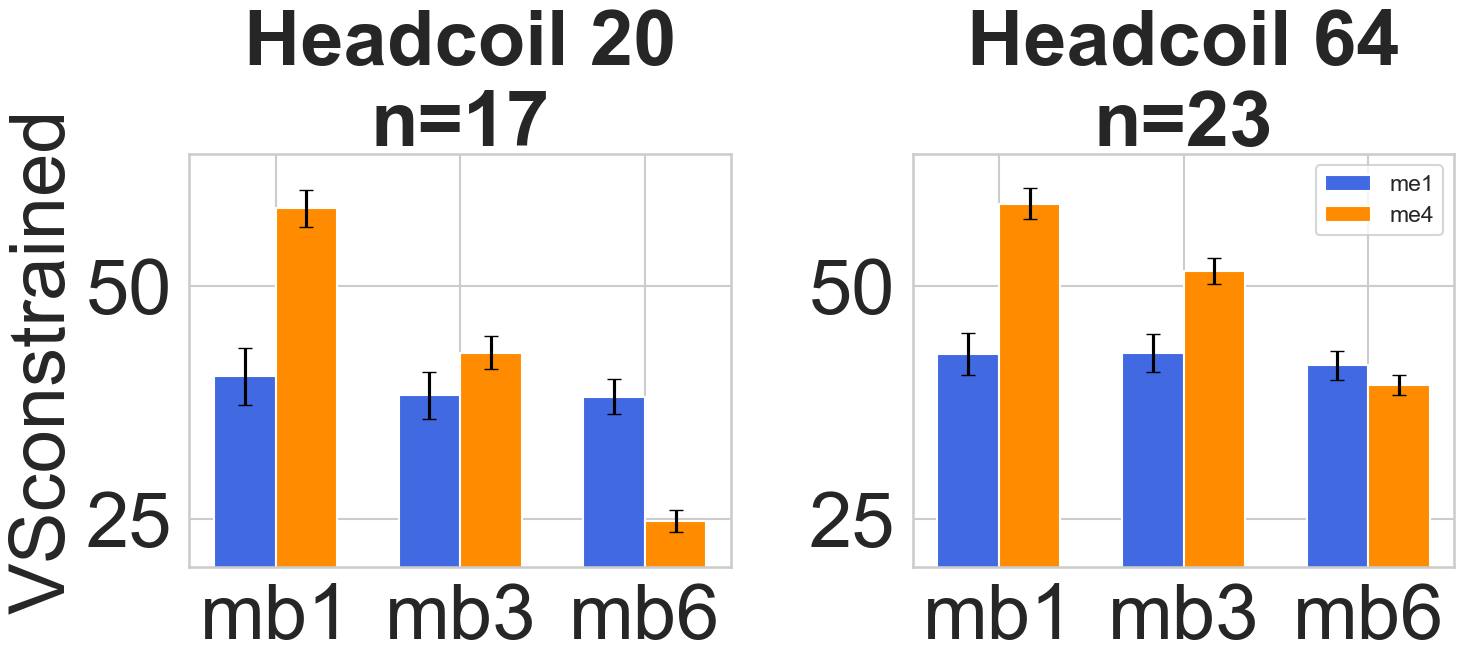

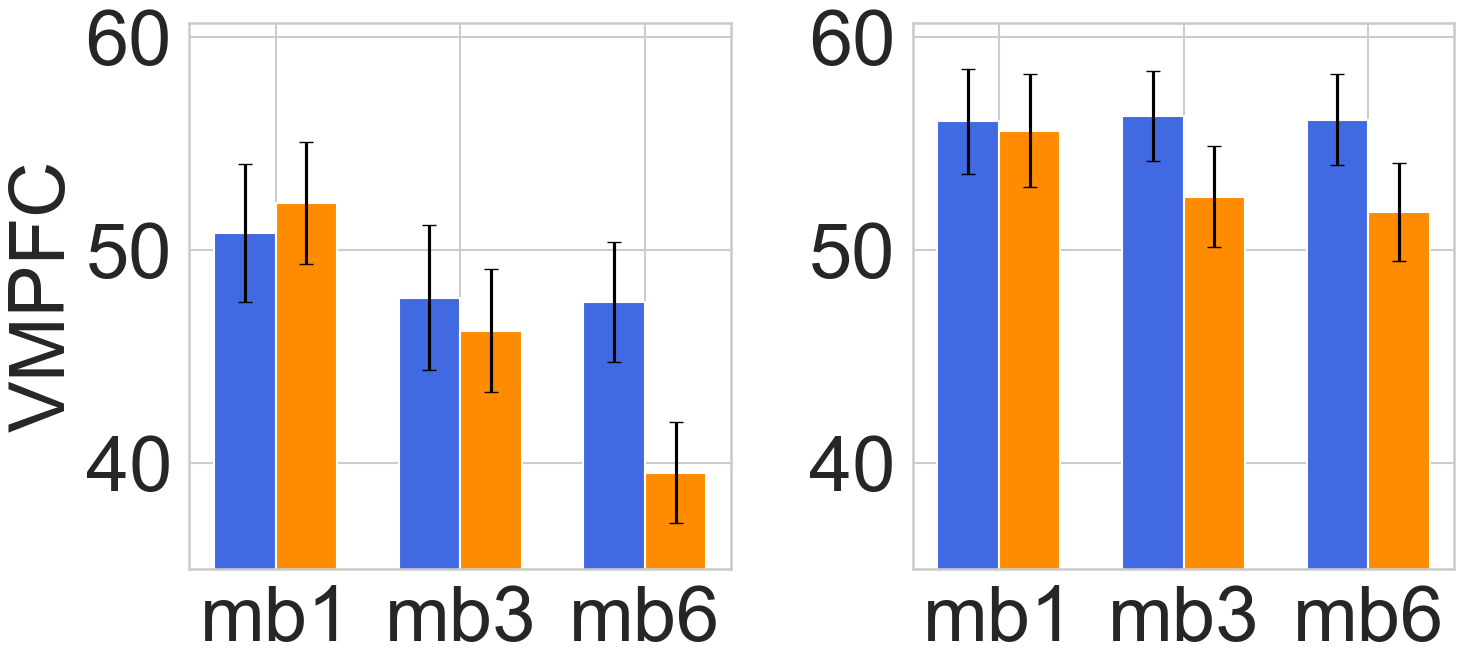

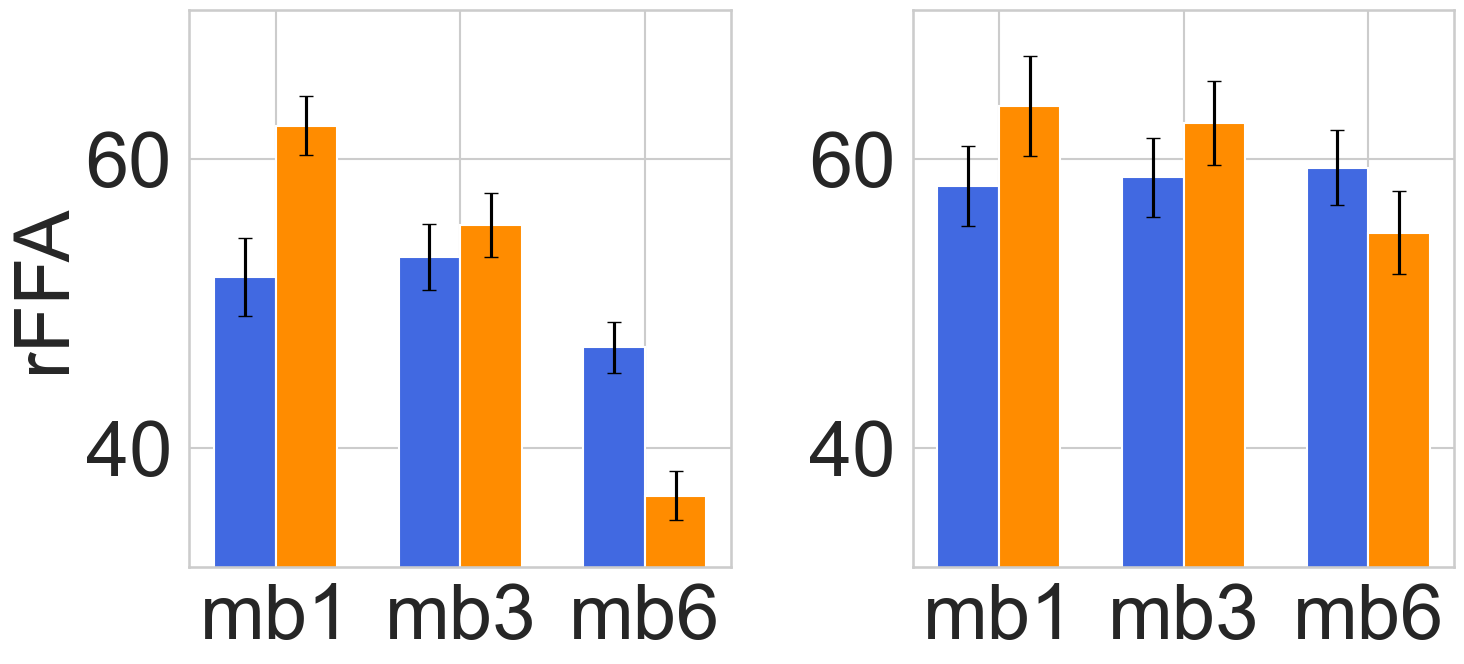

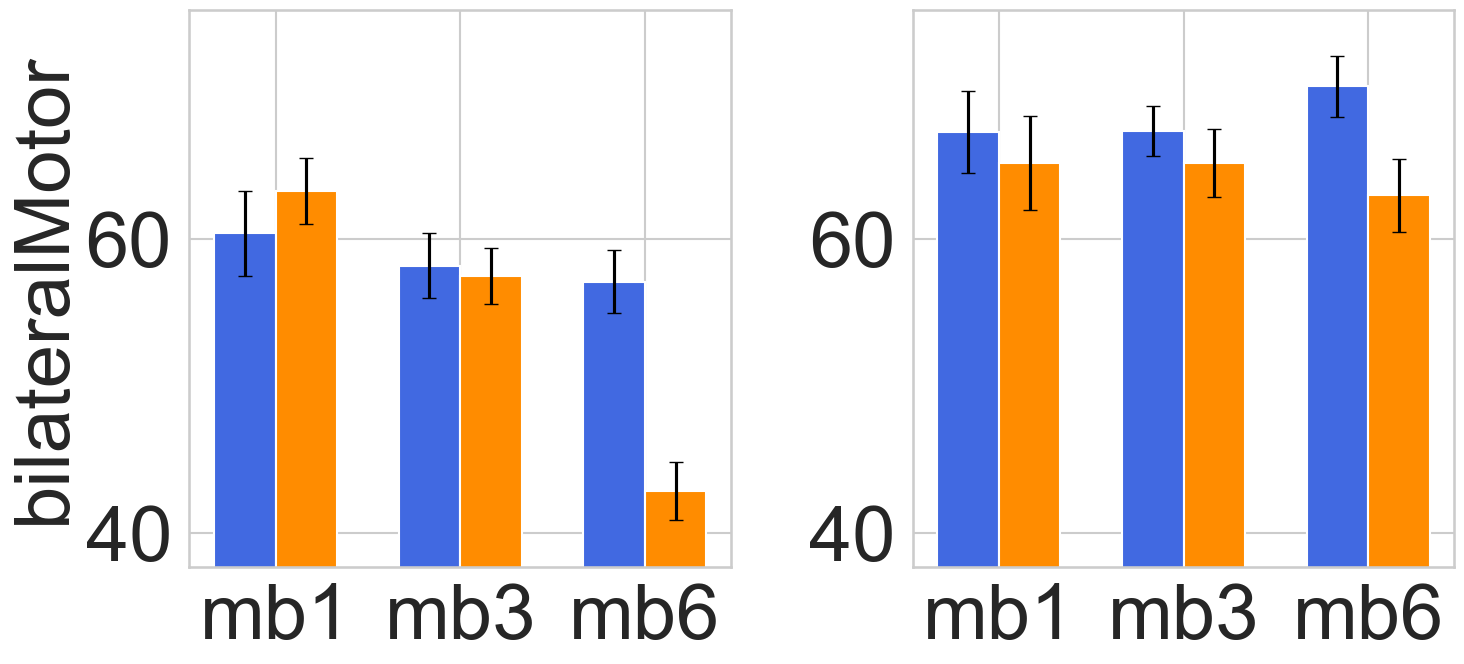

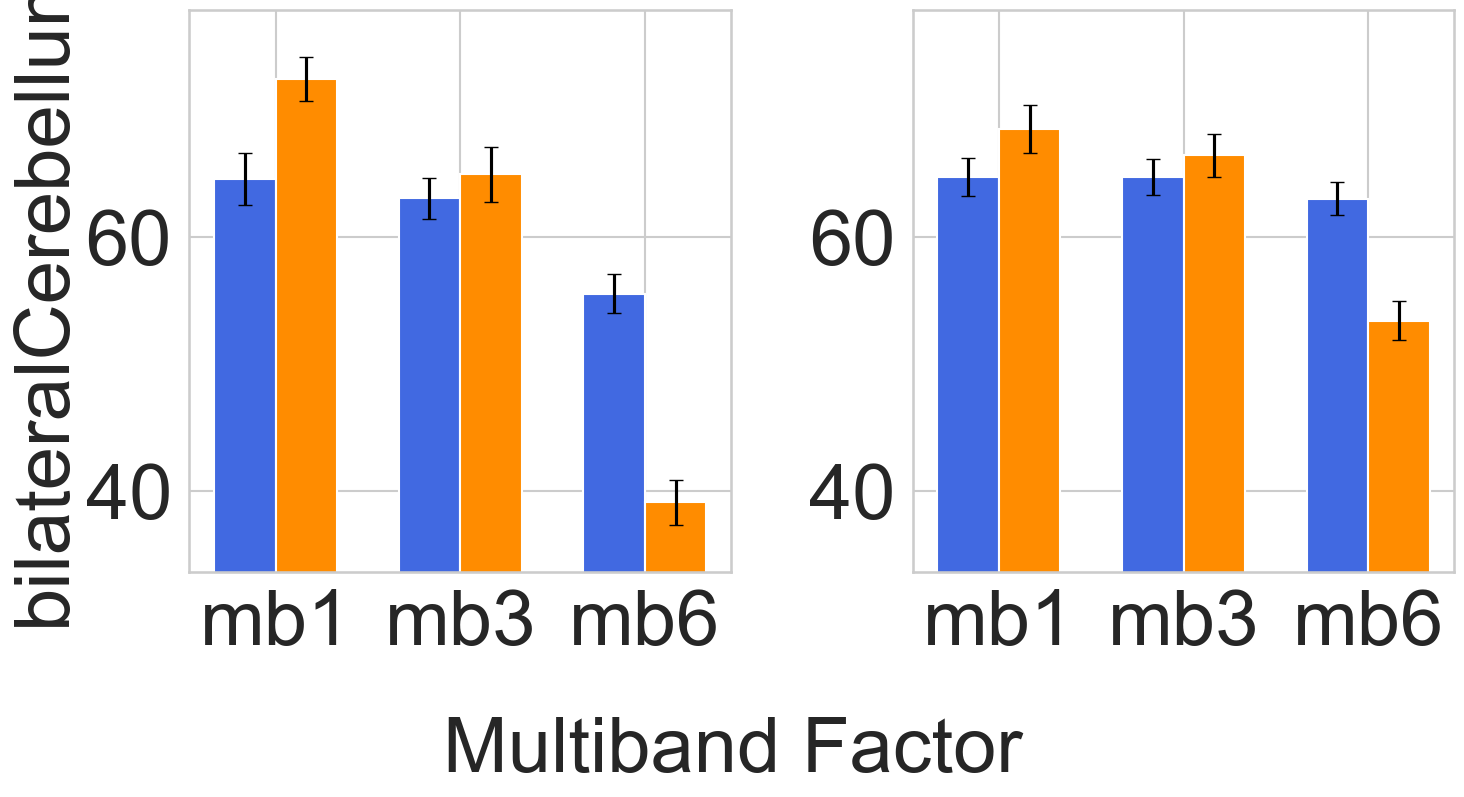

In [12]:
# Figure 5. TSNR by acquisition in each ROI
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "tsnr" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Beta

Processing files with parameters: type=act, img=beta, mask=VSconstrained, denoise=base
Using contrast: Rew>Pun
Data saved to multiecho_data_act_beta_VSconstrained_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
15    10017       64   -4.671750   94.225272 -104.142611 -162.286756   
14    10024       64  108.144702  171.678553  -71.579402  194.614259   
6     10035       64  177.945209   31.420981  -54.147004  346.247572   
38    10041       64  -49.422607  139.081973   60.893990  199.377341   
35    10043       64   40.083598  171.309089  261.922597  522.679206   

        mb3me4      mb6me4  
15   99.403756  -85.024436  
14  373.619278  223.327079  
6  -154.840010   11.494569  
38   85.674422  407.643753  
35  311.496890  234.641249  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                      Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         beta      
No. Observations:           240             Method:                     REML      
No. Groups:                 40              Scale:                      64662.4933
Min. group size:            6               Log-Likelihood:             -1604.1949
Max. group size:            6               Converged:                  Yes       
Mean group size:            6.0                                                   
----------------------------------------------------------------------------------
                                    Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------------------------
Intercept                            61.624   61.674  0.999 0.318  -59.255 182.503
headcoil[T.64]                      -24.348   81.333 -0.299 0.765 -183.758 135.062
mb[T.mb3]                  

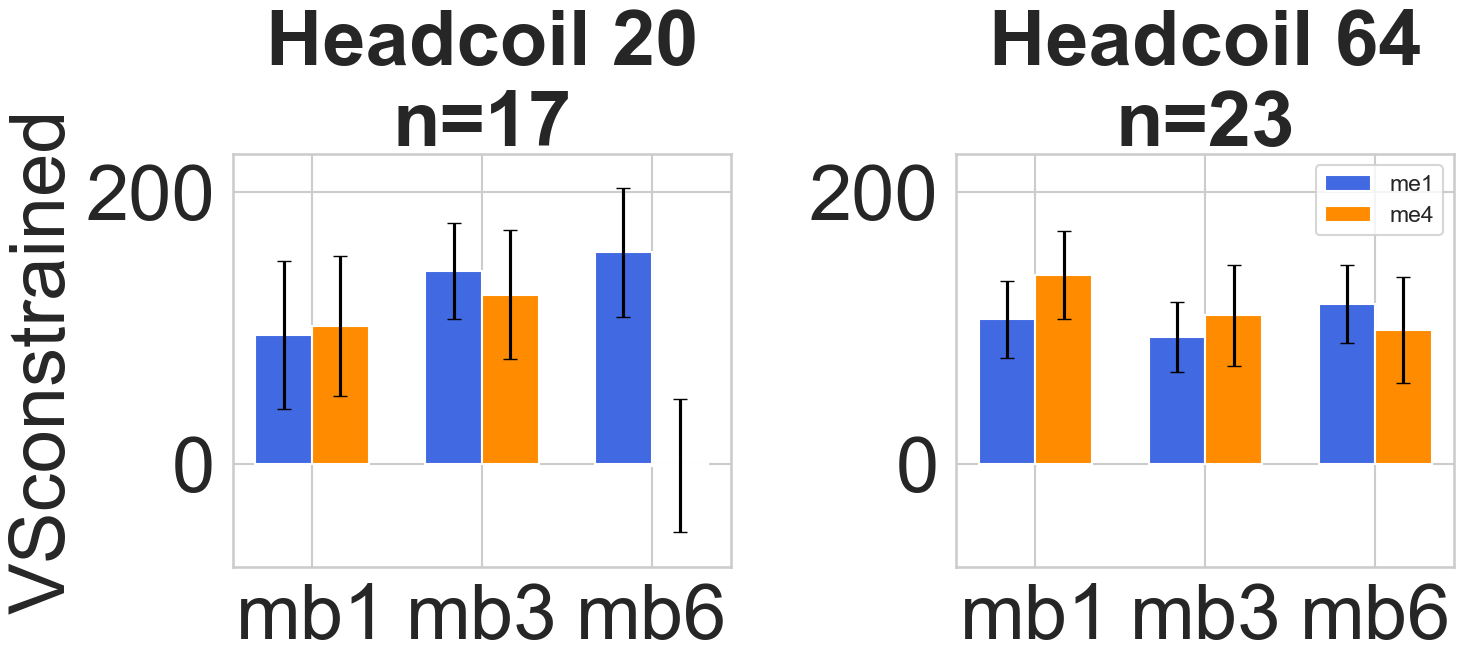

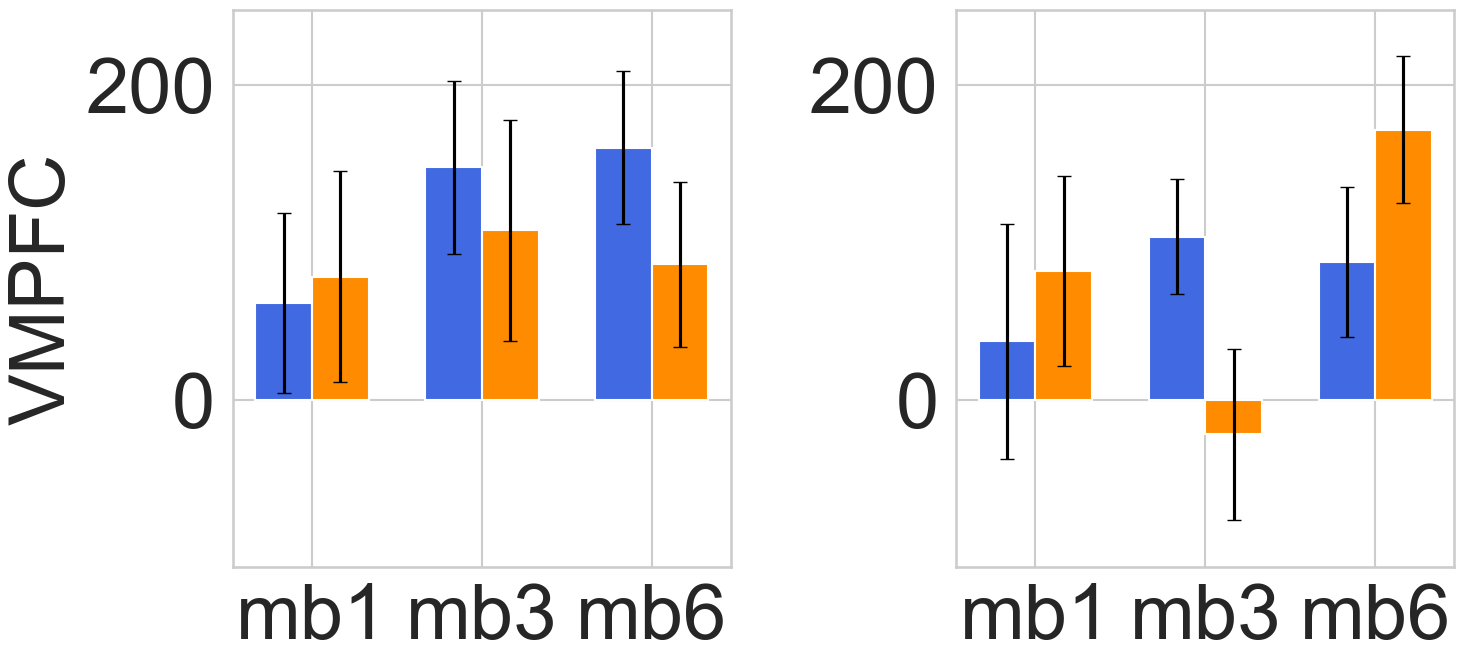

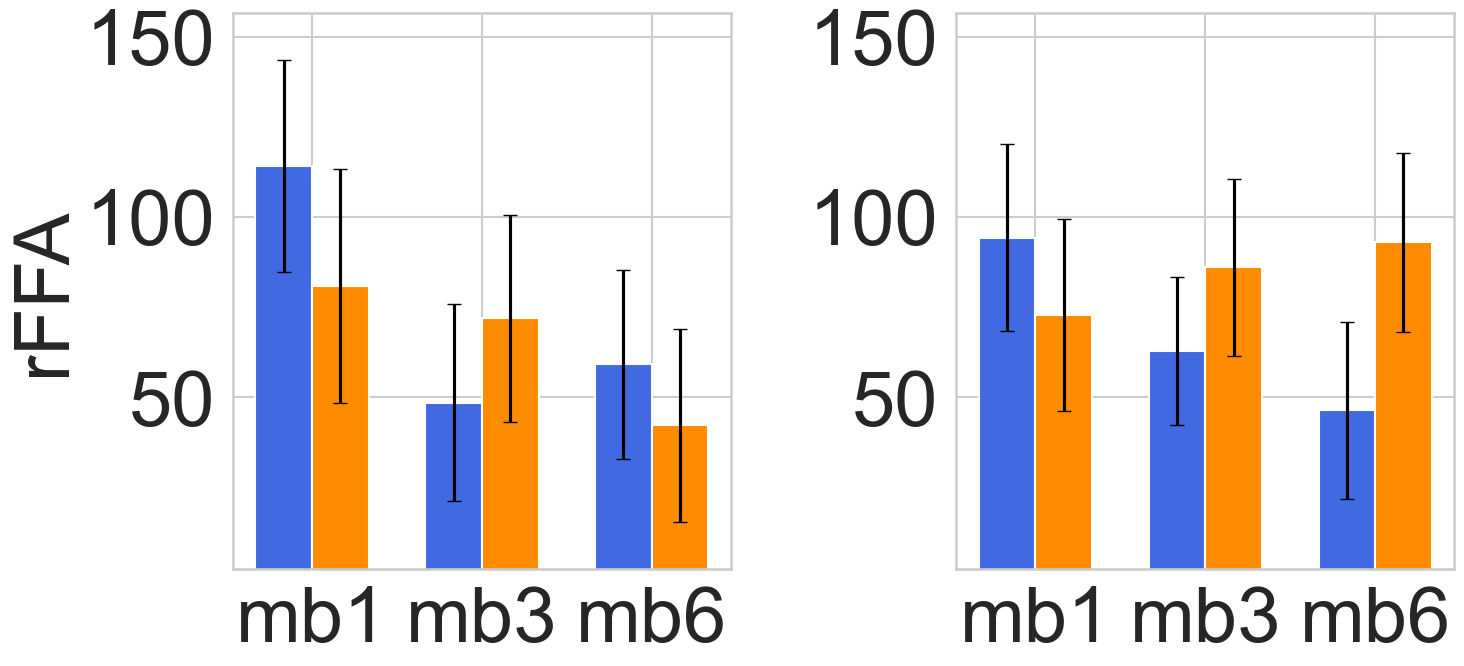

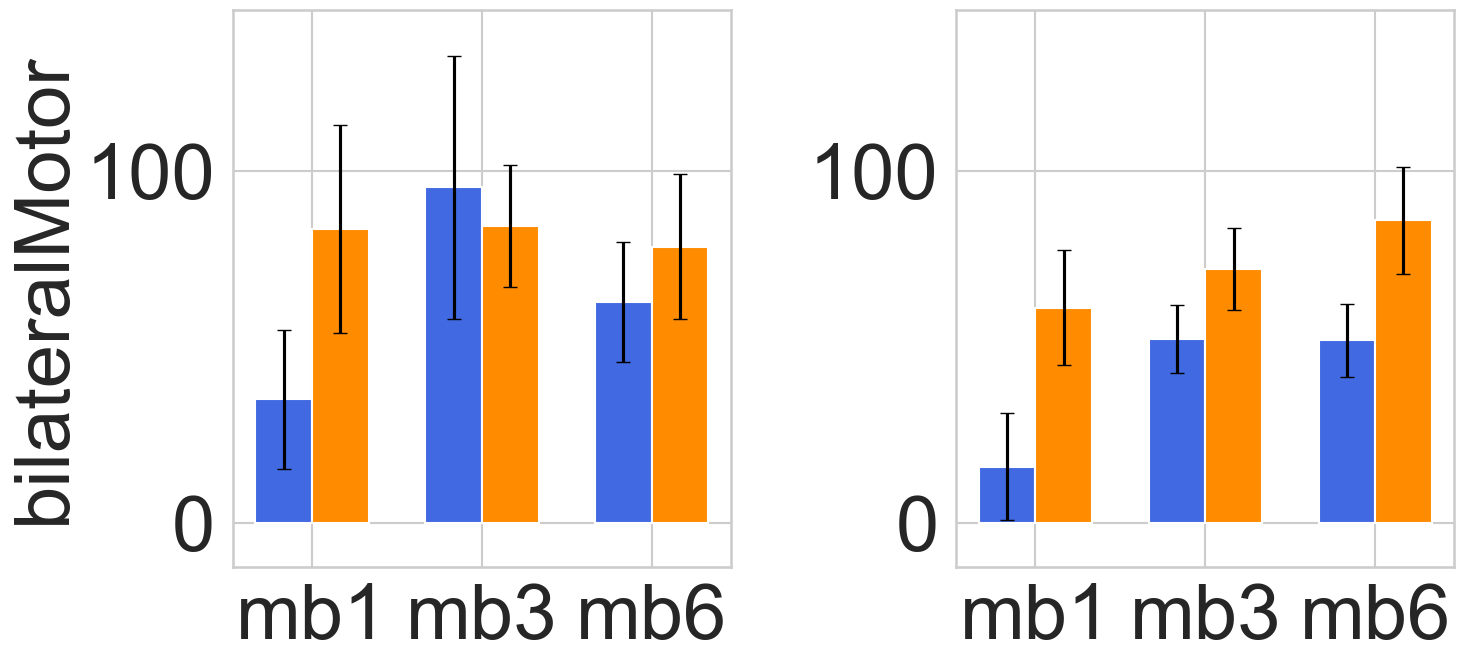

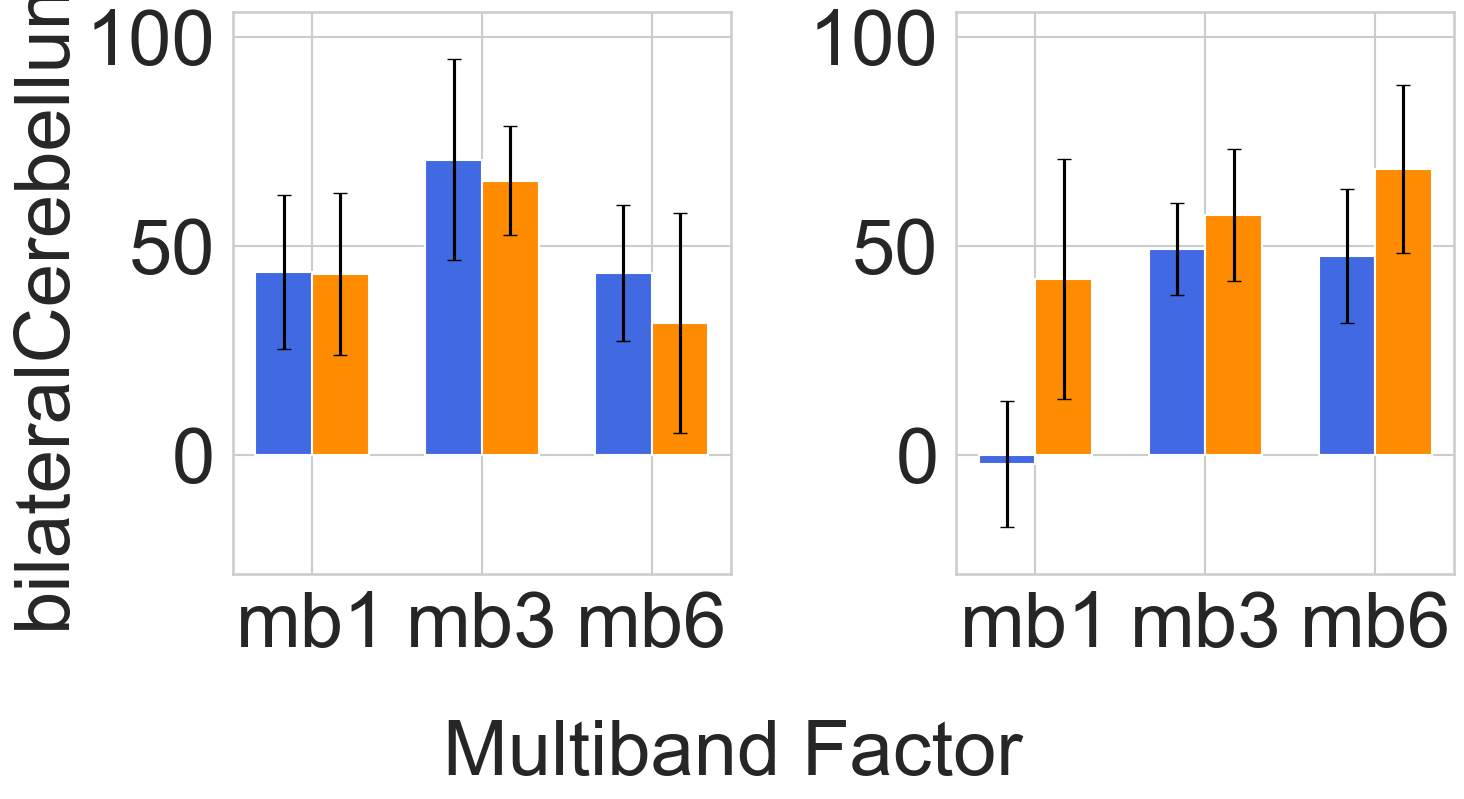

In [13]:
# Figure 6. Beta estimates for activation for each acquisition in each ROI
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Zstat

Processing files with parameters: type=act, img=zstat, mask=VSconstrained, denoise=base
Using contrast: Rew>Pun
Data saved to multiecho_data_act_zstat_VSconstrained_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
25    10017       64 -0.052341  0.092611 -0.226344 -0.109317  0.125530   
32    10024       64  0.222361  0.609214 -0.343321  0.342741  1.116233   
7     10035       64  0.413395  0.157308 -0.332888  0.638243 -0.496693   
23    10041       64 -0.214285  0.464856  0.229929  0.332726  0.233385   
37    10043       64  0.063261  0.582494  1.209953  0.798848  0.840201   

      mb6me4  
25 -0.068198  
32  0.733408  
7   0.036513  
23  1.281765  
37  0.677401  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1      0
mb6me1      0
mb1me4      0
mb3me4      0
mb6me4

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        zstat    
No. Observations:         240            Method:                    REML     
No. Groups:               40             Scale:                     0.2923   
Min. group size:          6              Log-Likelihood:            -201.6374
Max. group size:          6              Converged:                 Yes      
Mean group size:          6.0                                                
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.114    0.131  0.870 0.384 -0.143  0.372
headcoil[T.64]                      0.005    0.173  0.029 0.977 -0.335  0.345
mb[T.mb3]                           0.195    0.185  1.052 0.293 -0.168  0.559
mb[T.m

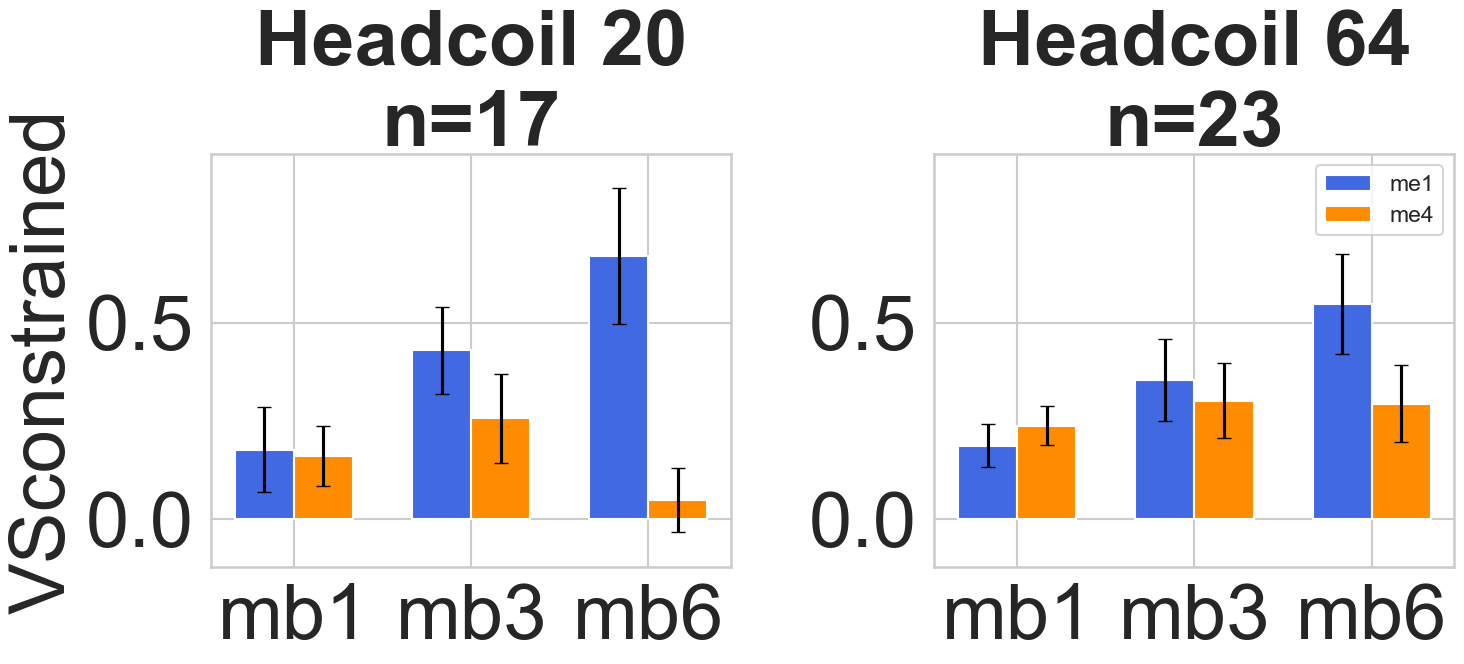

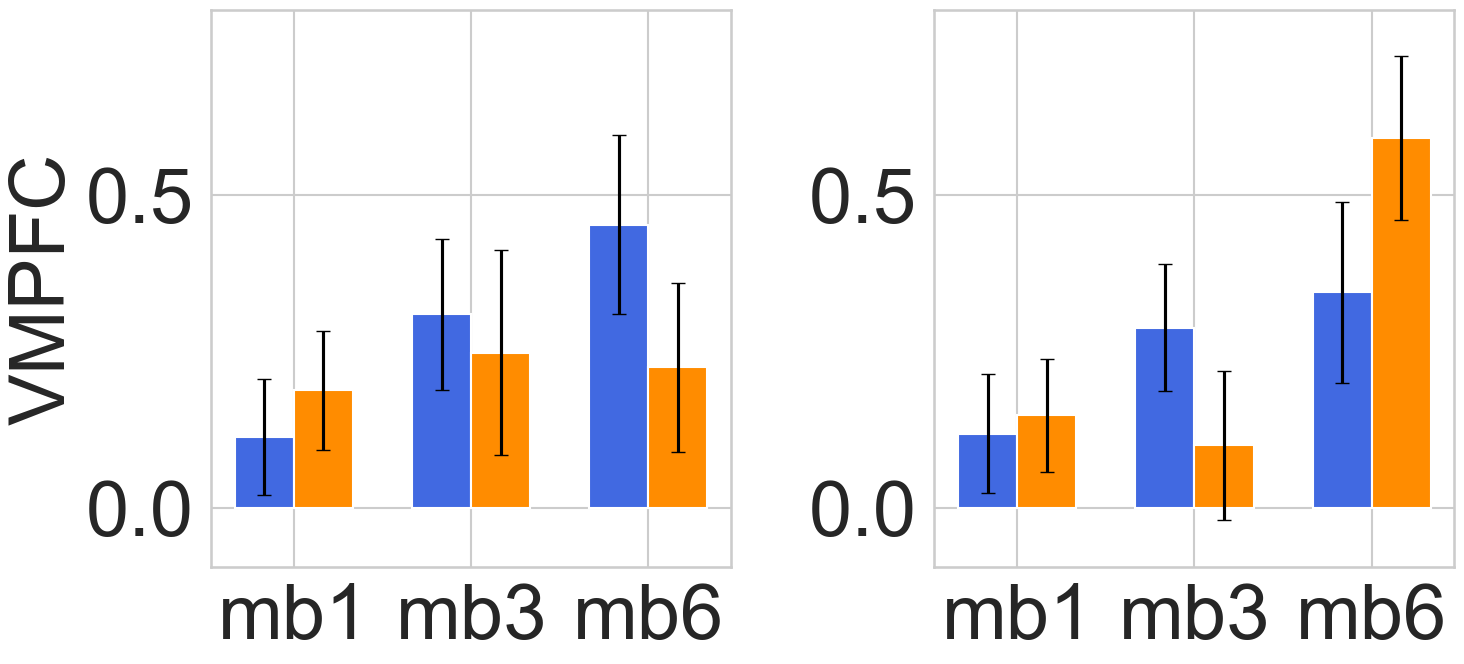

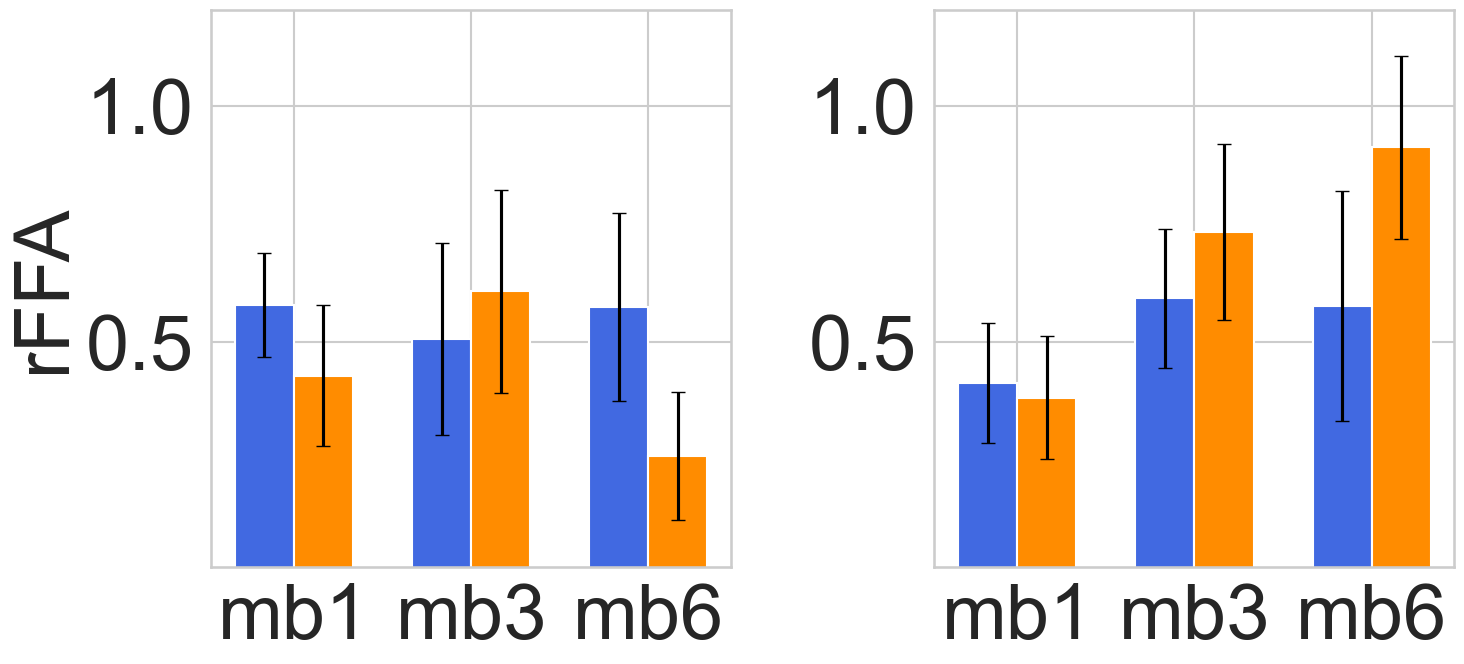

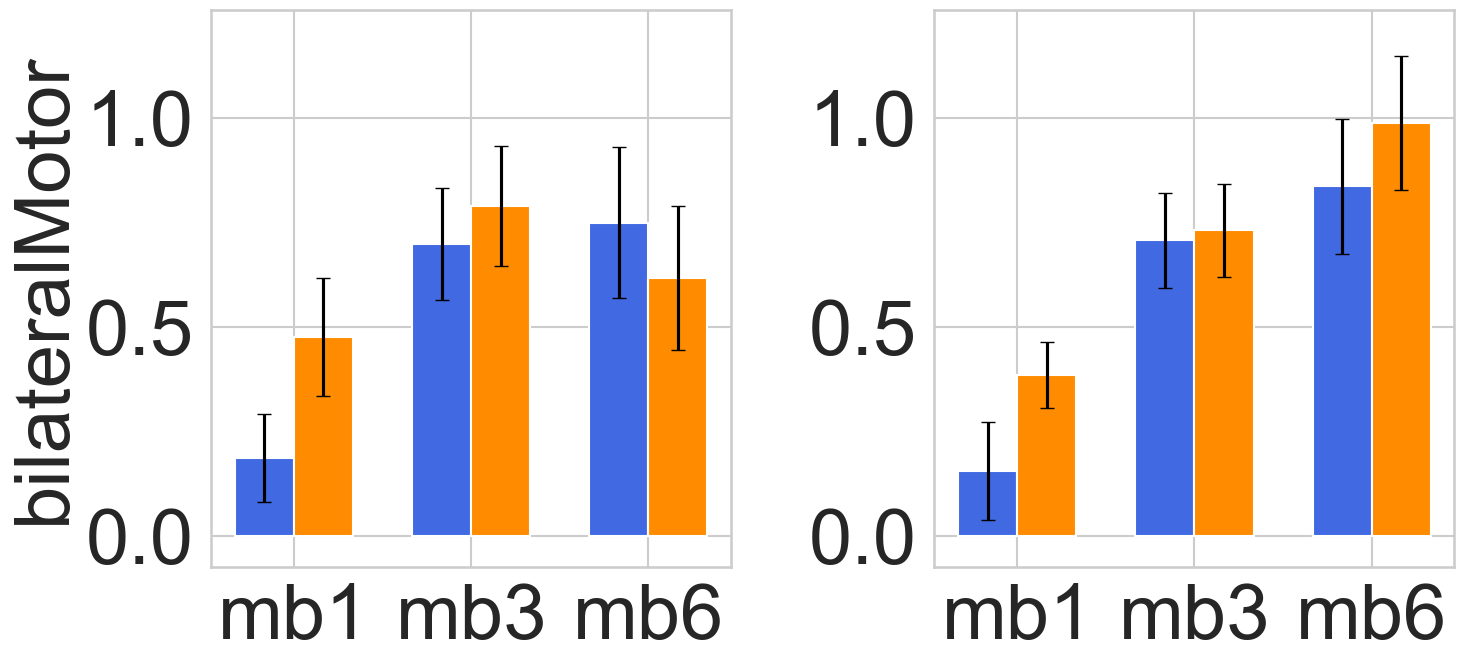

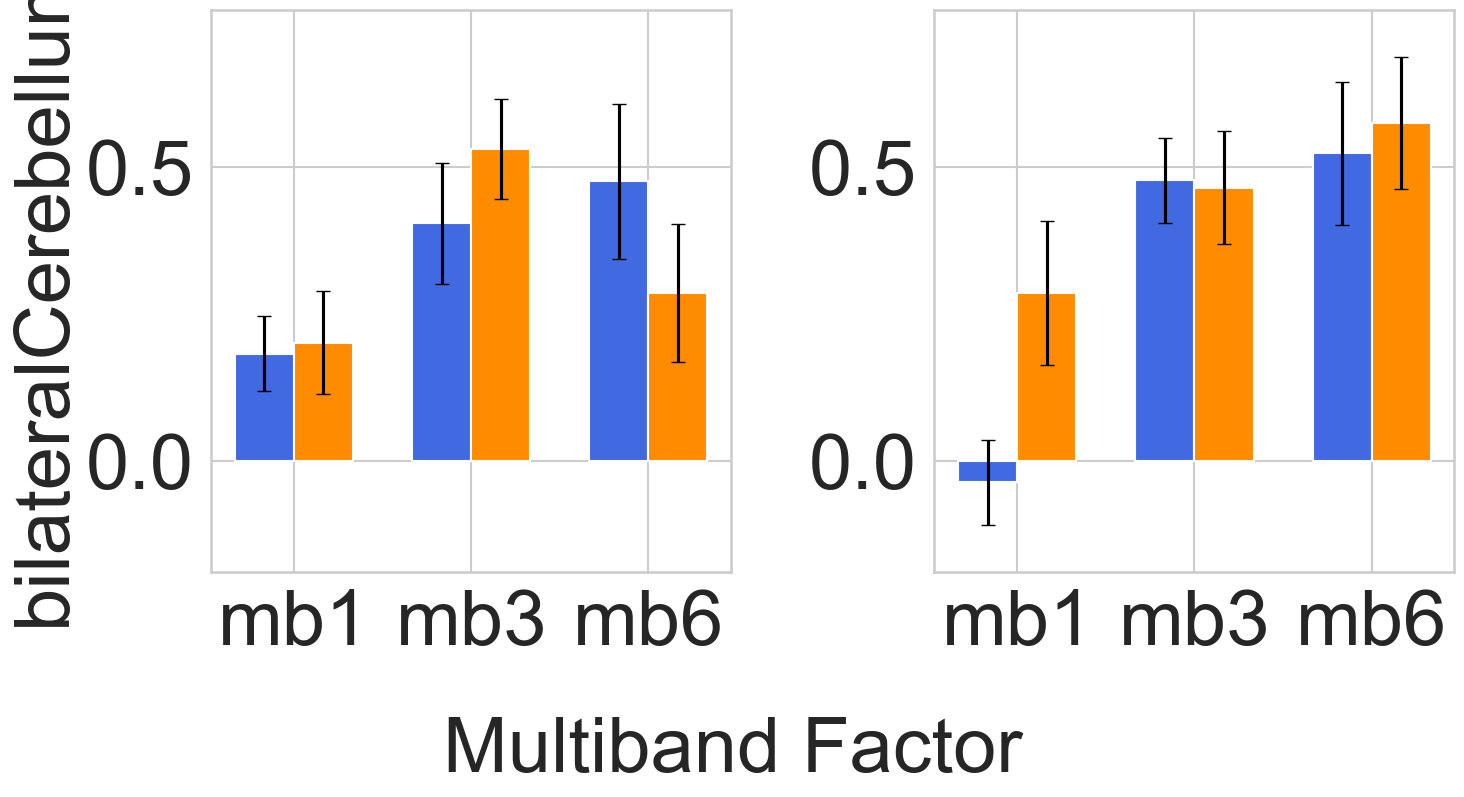

In [16]:
# Supp. Figure 6. zstats for activation for each acquisition in each ROI
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "zstat" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=PPI_SEED-VS_THR5, IMG_VALUE=Beta

Processing files with parameters: type=ppi_seed-VS_thr5, img=beta, mask=VMPFC, denoise=base
Using contrast: Rew>Pun
Data saved to multiecho_data_ppi_seed-VS_thr5_beta_VMPFC_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil     mb1me1    mb3me1    mb6me1     mb1me4     mb3me4  \
25    10017       64  89.297388  3.913389  3.338511  57.453720  18.124263   
2     10024       64  -4.599379  0.440359 -0.649661   8.634791   2.706911   
4     10035       64   0.774104 -5.131424 -2.803471  -3.788675  -1.941951   
28    10041       64  -8.152401  2.219746  0.854800  -1.913513   4.673571   
31    10043       64  -2.994230  0.318628  1.226043   7.946105  -0.549515   

      mb6me4  
25  5.610220  
2  -0.759237  
4   0.132748  
28 -1.609837  
31 -0.567247  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1      0
mb6me1    

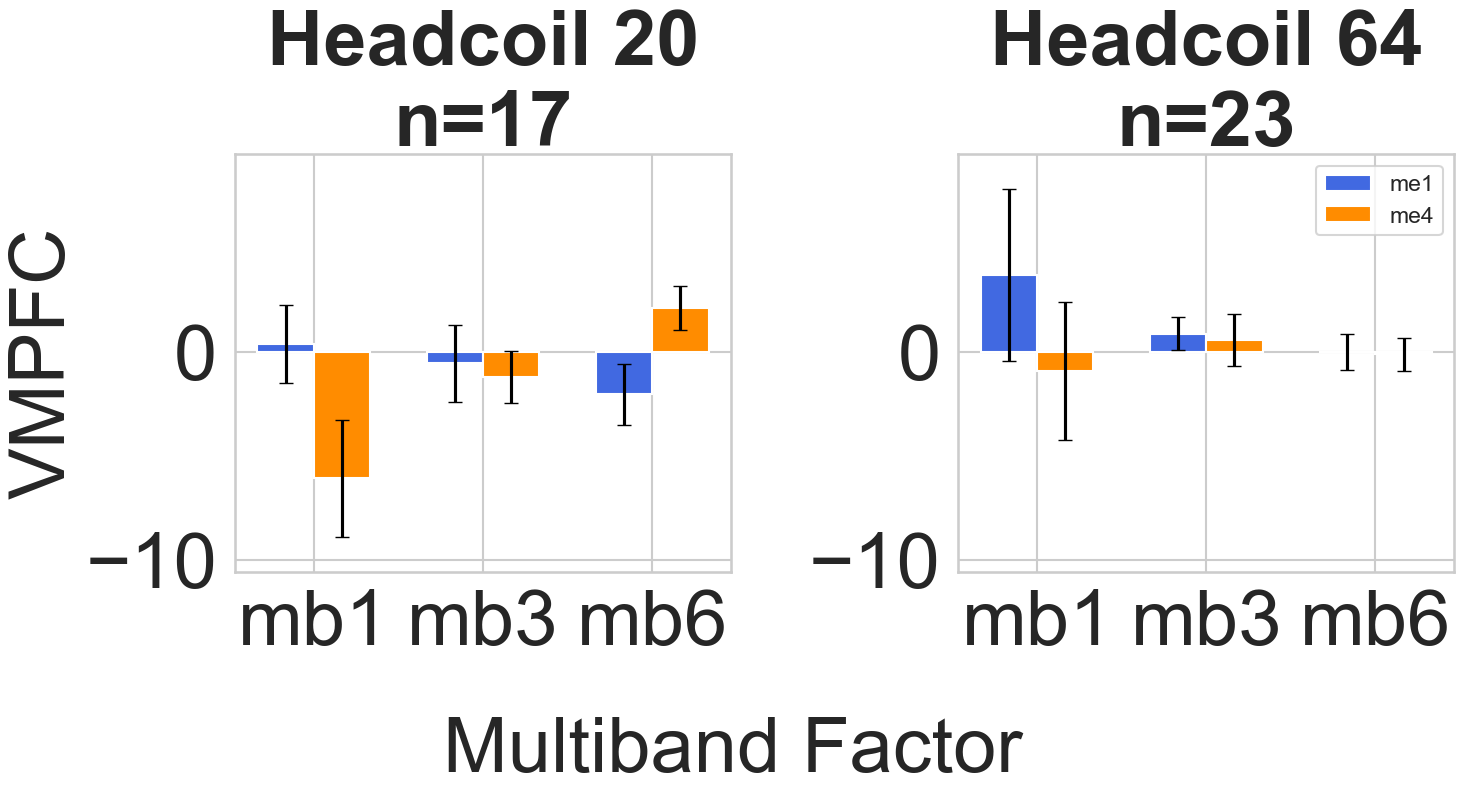

In [18]:
# Figure 7. Beta estimates for ppi for each acquisition in VMPFC
TYPE_VALUE = "ppi_seed-VS_thr5" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VMPFC"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=PPI_SEED-VS_THR5, IMG_VALUE=Zstat

Processing files with parameters: type=ppi_seed-VS_thr5, img=zstat, mask=VMPFC, denoise=base
Using contrast: Rew>Pun
Data saved to multiecho_data_ppi_seed-VS_thr5_zstat_VMPFC_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
17    10017       64  0.406330  0.138988  0.154490  0.129046  0.102802   
5     10024       64 -0.335370  0.036821 -0.105762  0.297115  0.305760   
19    10035       64  0.080598 -0.741936 -0.644463 -0.180664 -0.282070   
24    10041       64 -0.458875  0.396962  0.142223 -0.160802  0.325056   
34    10043       64 -0.172289  0.049024  0.278389  0.186595 -0.036370   

      mb6me4  
17  0.257606  
5  -0.045831  
19  0.059568  
24 -0.182981  
34 -0.049467  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1      0
mb6me1      0
mb1me4     

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        zstat    
No. Observations:         240            Method:                    REML     
No. Groups:               40             Scale:                     0.1535   
Min. group size:          6              Log-Likelihood:            -131.2078
Max. group size:          6              Converged:                 Yes      
Mean group size:          6.0                                                
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.009    0.097  0.096 0.924 -0.180  0.199
headcoil[T.64]                     -0.021    0.127 -0.165 0.869 -0.271  0.229
mb[T.mb3]                          -0.032    0.134 -0.238 0.812 -0.295  0.231
mb[T.m

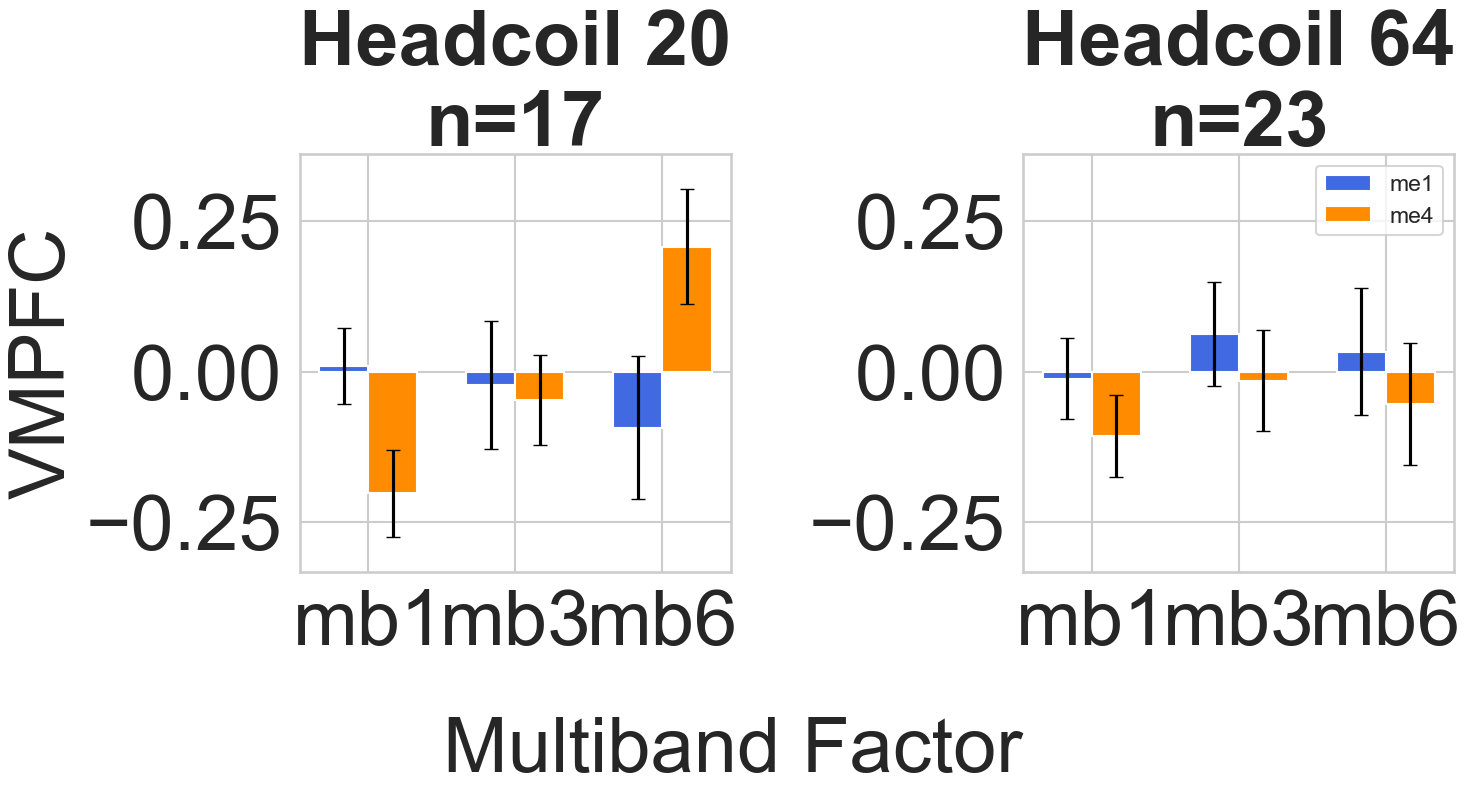

In [20]:
# Supp. Figure 7. zstats for ppi for each acquisition in VMPFC
TYPE_VALUE = "ppi_seed-VS_thr5" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "zstat" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VMPFC"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=PPI_SEED-VS_THR5, IMG_VALUE=Beta

Processing files with parameters: type=ppi_seed-VS_thr5, img=beta, mask=MEbonf, denoise=base
Using contrast: Unknown
Data saved to multiecho_data_ppi_seed-VS_thr5_beta_MEbonf_base_Unknown.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
15    10017       64  0.486777  0.388941  0.170893  0.839128  0.613383   
12    10024       64  0.094442  0.222161  0.350732  0.119211 -0.029392   
25    10035       64  0.015217  0.288969  0.156517  0.441444  0.101959   
20    10041       64 -0.165057  0.259974  0.281639  0.798387 -0.223576   
34    10043       64 -0.357800 -0.039439  0.198245  1.034978  0.493550   

      mb6me4  
15  0.400882  
12  0.418424  
25 -0.001471  
20  0.229793  
34  0.293688  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1      0
mb6me1      0
mb1me4      0

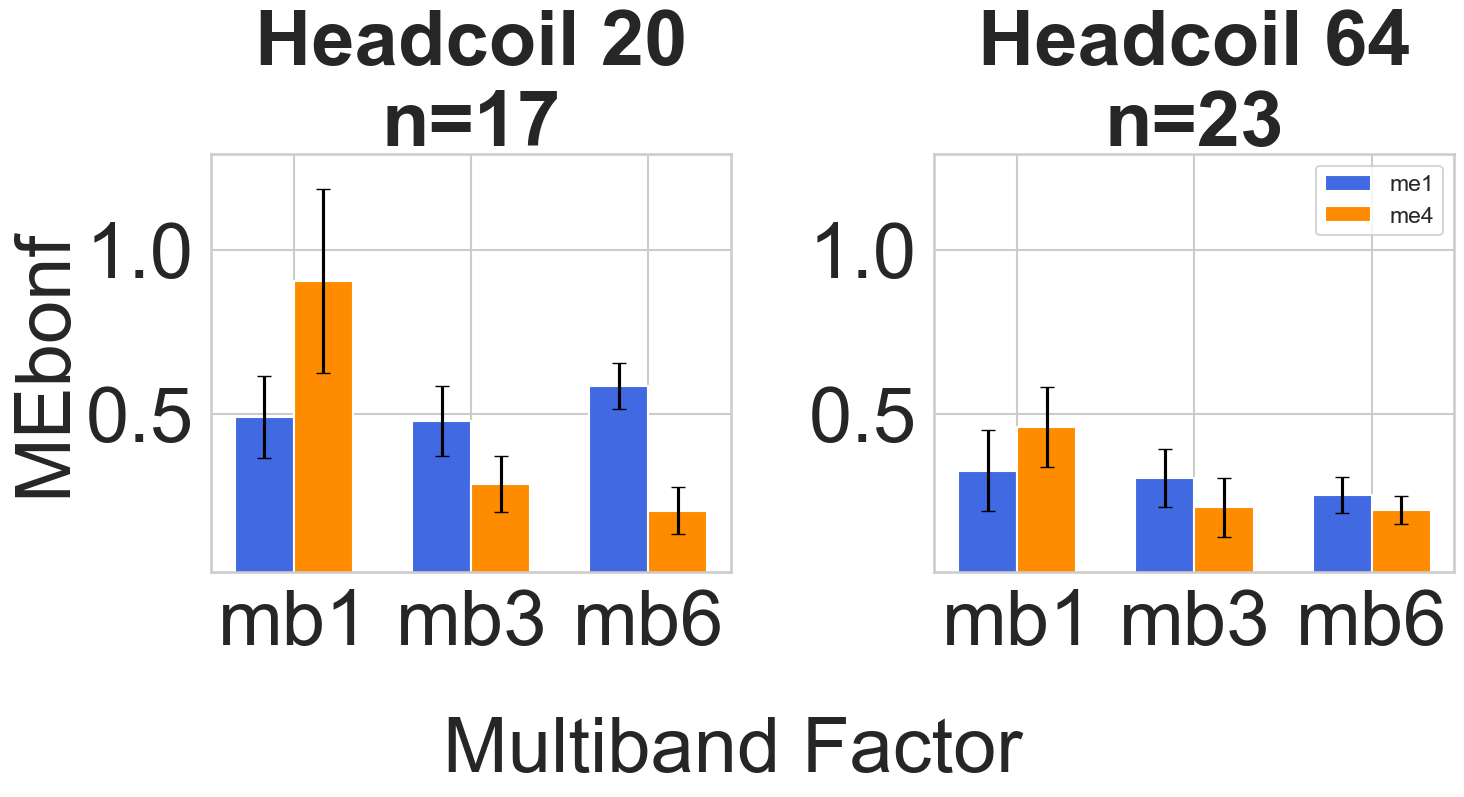

In [22]:
# LME
TYPE_VALUE = "ppi_seed-VS_thr5" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["MEbonf"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=PPI_SEED-VS_THR5, IMG_VALUE=Beta

Processing files with parameters: type=ppi_seed-VS_thr5, img=beta, mask=HCxMEbonf, denoise=base
Using contrast: Unknown
Data saved to multiecho_data_ppi_seed-VS_thr5_beta_HCxMEbonf_base_Unknown.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
17    10017       64  0.203739  0.082983  0.215631  0.423486  0.381277   
22    10024       64  0.579353  0.435715  0.385691  0.553665  0.416106   
25    10035       64  0.418350 -0.018536  0.358205  0.227374 -0.025990   
36    10041       64 -0.389665 -0.061145  0.267286  0.236136  0.293913   
1     10043       64 -0.381371 -0.062987  0.287128  0.877632  0.281280   

      mb6me4  
17  0.206153  
22  0.451838  
25  0.008355  
36  0.071903  
1   0.322555  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1      0
mb6me1      0
mb1me4 

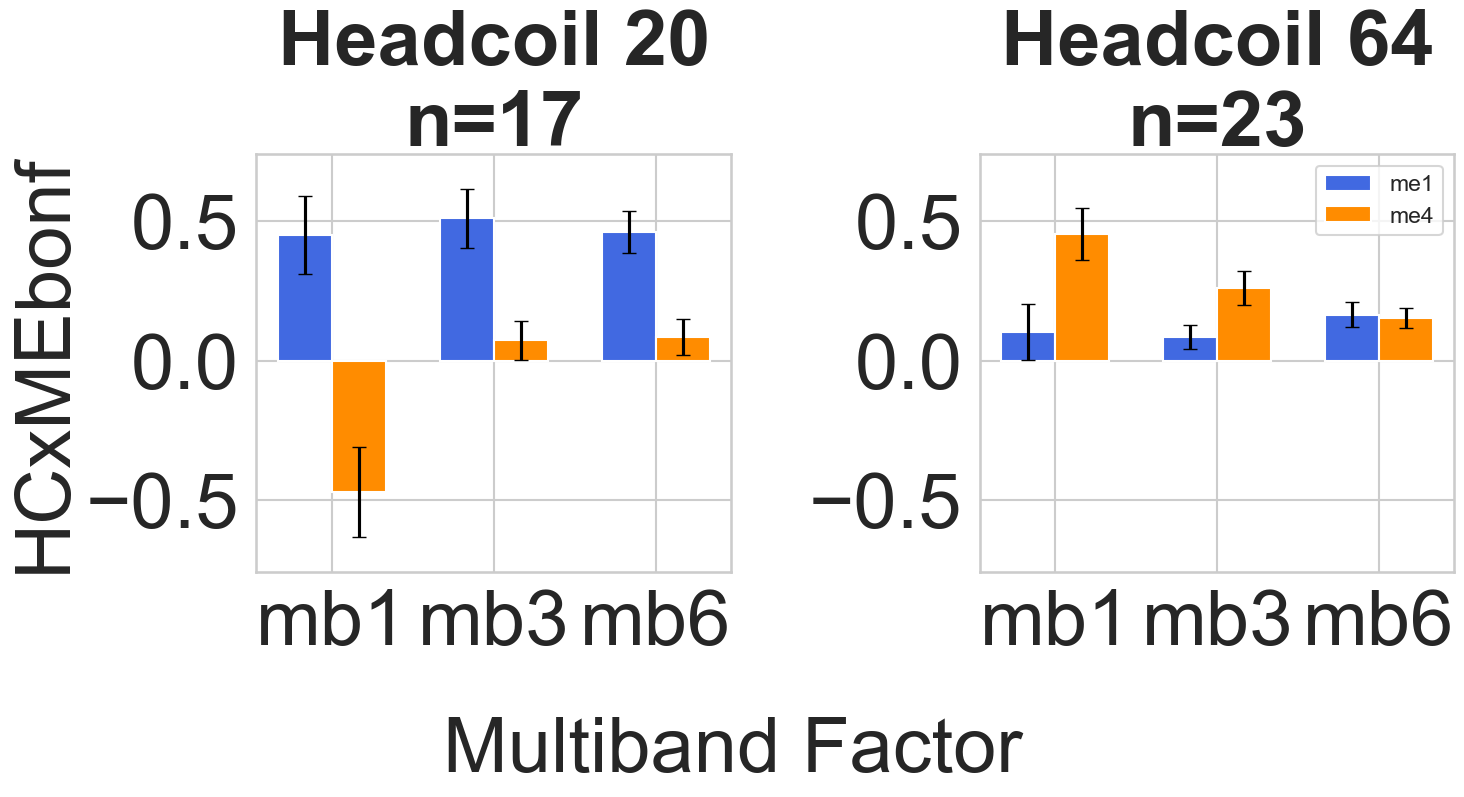

In [24]:
# LME
TYPE_VALUE = "ppi_seed-VS_thr5" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["HCxMEbonf"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=PPI_SEED-VS_THR5, IMG_VALUE=Beta

Processing files with parameters: type=ppi_seed-VS_thr5, img=beta, mask=3waybonf, denoise=base
Using contrast: Unknown
Data saved to multiecho_data_ppi_seed-VS_thr5_beta_3waybonf_base_Unknown.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
17    10017       64  0.684160 -0.128641  0.312095  0.475833  0.900211   
11    10024       64  0.382074 -0.018033  0.291868 -1.074285 -0.646402   
33    10035       64  1.911335  0.642379  1.156153 -0.071363 -0.471017   
35    10041       64 -1.024630 -0.028349  0.084596  0.757710  0.611920   
6     10043       64 -0.514169  0.339286  0.713070  2.427103  0.808691   

      mb6me4  
17  0.347780  
11  0.311822  
33  0.159031  
35 -0.257437  
6   0.686846  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1      0
mb6me1      0
mb1me4   

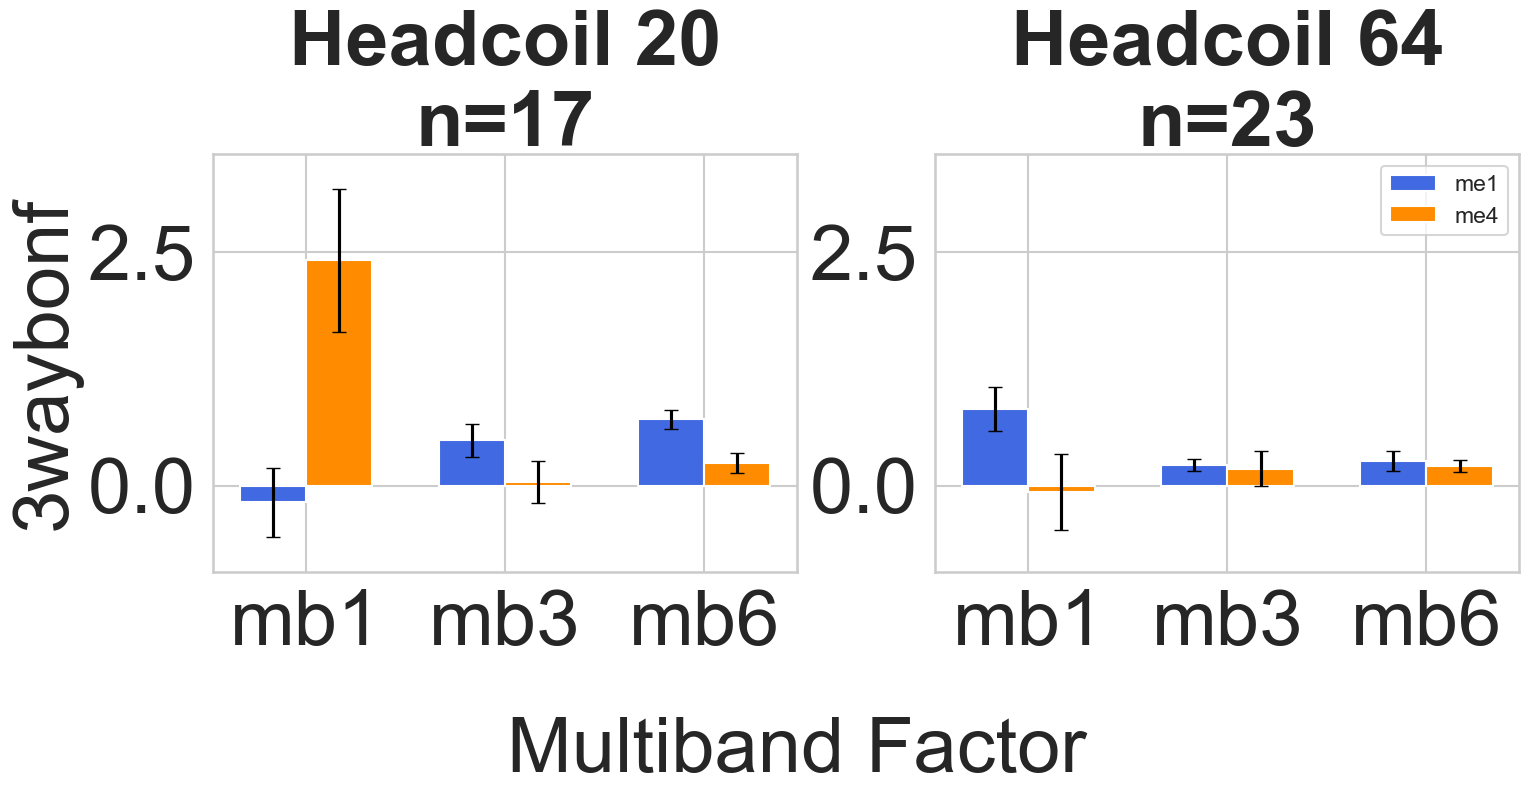

In [26]:
# LME
TYPE_VALUE = "ppi_seed-VS_thr5" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["3waybonf"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)

# Fig 8. Analysis of Tedana vs. Base Denoising Effects with Framewise Displacement

This combined code chunk processes framewise displacement (FD) data and fMRI metric differences between two denoising methods (Tedana and a baseline) across multiecho acquisitions (mb1me4, mb3me4, mb6me4), then visualizes the relationship between FD and denoising effects using scatter plots. It consists of two parts: (1) calculating average FD values per subject and acquisition, and (2) extracting, processing, and plotting the denoising differences with FD.

### Key Components
1. **FD Preprocessing (Part 1)**:
   - Loads a TSV file containing FD data (e.g., `Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv`).
   - Filters out subjects ending in `sp` and acquisitions with `me1`, retaining only `me4` data.
   - Saves filtered data as `fd_mean_values.csv`.
   - Groups data by subject and acquisition (e.g., `mb1me4`), computes mean `fd_mean` values, and saves results to `fd_mean_averages.xlsx`.

2. **Data Extraction and Difference Calculation (Part 2)**:
   - `extract_file_data_with_difference`: 
     - Parses text files in a directory (e.g., `~/Documents/GitHub/multiecho-pilot/derivatives/extractions`) matching a regex pattern.
     - Extracts metric values (e.g., beta) for specified denoising methods (`denoise_tedana`, `denoise_base`) across acquisitions (mb1me4, mb3me4, mb6me4).
     - Computes differences (`tedana - base`) per subject and acquisition, handling missing data with NaNs.

3. **Data Merging (Part 2)**:
   - `create_dataframe_with_fd`: 
     - Constructs a DataFrame from difference data, adding headcoil assignments (20 or 64 channels) based on a predefined subject list.
     - Merges with FD data from `fd_mean_values.csv`, aligning on subject and acquisition.
     - Reshapes to long format with columns: `subject`, `headcoil`, `acq`, `tedana_minus_base`, and `fd_mean`.

4. **Visualization (Part 2)**:
   - `create_scatter_plots`: 
     - Generates two sets of scatter plots (one per acquisition):
       - **Set 1**: Splits by headcoil (red for 20, green for 64), with regression lines per headcoil.
       - **Set 2**: Combines all data (blue dots), with a single regression line.
     - X-axis: Mean FD; Y-axis: Tedana minus base difference; Subplots: One per acquisition.
   - `initialize_plotting_engine`: Sets large fonts and a whitegrid style for readability.

5. **Execution (Part 2)**:
   - `process_and_visualize_tedana_difference`: 
     - Orchestrates the workflow: extracts differences, merges with FD, and creates plots.
     - Saves merged data as CSV and plots as PNG if `save_files=True`.

### Inputs
- **Part 1**:
  - `input_file`: TSV file with FD data (e.g., `~/.../Outlier-info_mriqc-0.16.1.tsv`).
- **Part 2**:
  - `base_dir`: Directory with fMRI text files (default: `~/.../extractions`).
  - `type_value`: Analysis type (e.g., `act`).
  - `img_value`: Metric (e.g., `beta`).
  - `mask_value`: ROI (e.g., `VSconstrained`).
  - `denoise_tedana`, `denoise_base`: Denoising methods (e.g., `tedana`, `smooth`).
  - `fd_csv_path`: Path to FD CSV (default: `fd_mean_values.csv` from Part 1).
  - `acq_params`: Acquisitions (default: `["mb1me4", "mb3me4", "mb6me4"]`).
  - `headcoil_64_subjects`: List of subjects with 64-channel headcoils.

### Outputs
- **Part 1**:
  - `fd_mean_values.csv`: Filtered FD data.
  - `fd_mean_averages.xlsx`: Averaged FD per subject and acquisition.
- **Part 2**:
  - **DataFrame**: Saved as `multiecho_tedana_minus_base_<type>_<img>_<mask>.csv`.
  - **Plots**: Two PNG files (e.g., `tedana_minus_base_scatter_<type>_<img>_<mask>.png`) with headcoil-split and combined scatter plots.

### Notes
- Assumes `me4` acquisitions are the focus; `me1` data is excluded.
- Handles missing data by skipping invalid files and reporting NaNs in merges.
- Plot aesthetics (e.g., font size=56, dot size=300) are optimized for publication clarity.
- The two parts are interdependent: Part 1 generates FD data used by Part 2.

This workflow supports Figure 8 by linking head motion (FD) to denoising effects across acquisition types and headcoils, providing visual and tabular insights into data quality trade-offs.

In [29]:
# Figure 8 Part 1, Generate avg fd_mean values for each ME acq
import pandas as pd

# Define file paths
input_file = "~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv"
output_file = "~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv"

# Load the TSV file
df = pd.read_csv(input_file, sep="\t")

# Filter out subjects ending in 'sp' and acquisitions containing 'me1'
df = df[~df['Sub'].str.endswith('sp')]
df = df[~df['acq'].str.contains('me1', na=False)]

# Save the filtered DataFrame to a CSV file
df.to_csv(output_file, index=False)

#print("Filtered data saved to:", output_file)

import pandas as pd

# Load your spreadsheet data
df = pd.read_csv(output_file)

# Extract the base 'acq' substring (e.g., mb1me4, mb3me4, mb6me4) from the 'acq' column
df['acq_base'] = df['acq'].str.extract(r'(mb\dme4)')

# Group by 'Sub' and 'acq_base' and calculate the average of 'fd_mean' for each group
averages = df.groupby(['Sub', 'acq_base'])['fd_mean'].mean().reset_index()

# Save the results to a new spreadsheet
output_file_path = 'fd_mean_averages.xlsx'  # Replace with your desired output file path
averages.to_excel(output_file_path, index=False)

# Optionally, print the averages to verify
print(averages)


          Sub acq_base   fd_mean
0   sub-10017   mb1me4  0.065809
1   sub-10017   mb3me4  0.093968
2   sub-10017   mb6me4  0.087372
3   sub-10028   mb1me4  0.043817
4   sub-10028   mb3me4  0.082697
..        ...      ...       ...
86  sub-10716   mb3me4  0.579043
87  sub-10738   mb1me4  0.326083
88  sub-12042   mb1me4  0.091052
89  sub-12042   mb3me4  0.103584
90  sub-12042   mb6me4  0.100240

[91 rows x 3 columns]


In [31]:
# Figure 8 part 2, define function for Figure 8 plots

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

def initialize_plotting_engine():
    """Initialize the plotting environment with required settings"""
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")
    # Significantly increase font size
    plt.rcParams.update({'font.size': 56})

def extract_file_data_with_difference(base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params):
    """Extract data and calculate differences between denoise methods for given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    print(f"Found {len(file_paths)} files in {base_dir}")
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or acq not in acq_params:
                continue
            if (file_type == type_value and img == img_value and mask == mask_value and 
                denoise in [denoise_tedana, denoise_base]):
                try:
                    with open(file_path, 'r') as f:
                        raw_content = f.read().strip()
                        value = float(raw_content)
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {
                            denoise: {acq_param: np.nan for acq_param in acq_params}
                            for denoise in [denoise_tedana, denoise_base]
                        }
                    data_by_subject[sub_id][denoise][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    print(f"Subjects with data: {len(data_by_subject)}")
    
    diff_by_subject = {}
    for sub_id, data in data_by_subject.items():
        diff_by_subject[sub_id] = {}
        for acq in acq_params:
            tedana_val = data[denoise_tedana].get(acq, np.nan)
            base_val = data[denoise_base].get(acq, np.nan)
            diff = tedana_val - base_val if not (np.isnan(tedana_val) or np.isnan(base_val)) else np.nan
            diff_by_subject[sub_id][acq] = diff
    
    return diff_by_subject

def create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects):
    """Create and merge DataFrame with framewise displacement data"""
    df = pd.DataFrame.from_dict(diff_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['subject'] = df['subject'].astype(str)
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in headcoil_64_subjects else 20)
    column_order = ['subject', 'headcoil'] + acq_params
    df = df[column_order]
    df.sort_values('subject', inplace=True)
    
    df_long = df.melt(id_vars=['subject', 'headcoil'], value_vars=acq_params, 
                      var_name='acq', value_name='tedana_minus_base')
    
    fd_df = pd.read_csv(fd_csv_path)
    fd_df = fd_df.rename(columns={'Sub': 'subject', 'acq_base': 'acq'})
    fd_df['subject'] = fd_df['subject'].str.replace('sub-', '', regex=False)
    fd_df['acq'] = fd_df['acq'].str.extract(r'(mb[1-6]me\d)')
    
    df_merged = pd.merge(df_long, fd_df[['subject', 'acq', 'fd_mean']], 
                         on=['subject', 'acq'], how='left')
    
    nan_count = df_merged['fd_mean'].isna().sum()
    print(f"\nNumber of NaN fd_mean values after merge: {nan_count} out of {len(df_merged)} rows")
    
    return df_merged

def create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base):
    """Create two batches of scatter plots:
       1. Split by headcoil (red for 20, green for 64)
       2. No split by headcoil (blue dots)
    """
    fig, axes = plt.subplots(1, len(acq_params), figsize=(24, 8), sharey=True)

    # Colors for headcoil scatter plots
    colors = {20: 'red', 64: 'green'}
    legend_handles = []

    for i, acq in enumerate(acq_params):
        ax = axes[i]
        acq_data = df[df['acq'] == acq]

        # Scatter plot with headcoil split
        scatter = sns.scatterplot(
            data=acq_data, x='fd_mean', y='tedana_minus_base',
            hue='headcoil', palette=colors, ax=ax, s=300  # Larger dots
        )

        # Capture legend handles for later use
        if i == 0:
            legend_handles = scatter.legend_.legendHandles

        # Regression lines for each headcoil
        for hc in [20, 64]:
            hc_data = acq_data[acq_data['headcoil'] == hc]
            if len(hc_data) > 1:  # Need at least 2 points for regression
                sns.regplot(x='fd_mean', y='tedana_minus_base', data=hc_data,
                            scatter=False, ax=ax, color=colors[hc], line_kws={'linewidth': 3})

        # Set title for each subplot
        ax.set_title(f'{acq}', fontsize=64, fontweight='bold')

        # Only add y-label to the first subplot
        if i == 0:
            ax.set_ylabel(f'{mask_value}\n{denoise_tedana} - {denoise_base}', fontsize=56)
        else:
            ax.set_ylabel('')

        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=56)

        # Remove individual legends
        ax.legend().remove()

        # Remove redundant x-labels (fd_mean under each plot)
        ax.set_xlabel('')

    # Fine-tuned x-axis label position (closer to ticks)
    fig.text(0.5, -0.02, 'Mean Framewise Displacement', ha='center', fontsize=56)

    # Adjust layout to make space for the legend
    plt.subplots_adjust(right=0.8)

    # Add a single legend outside the plots (with smaller text and simple labels)
    fig.legend(legend_handles, ['20', '64'], title='Headcoil',
               loc='center left', bbox_to_anchor=(1, 0.5), fontsize=28, title_fontsize=28)

    plt.tight_layout()

    # Create second batch of plots (no headcoil split, all dots blue)
    fig2, axes2 = plt.subplots(1, len(acq_params), figsize=(24, 8), sharey=True)

    for i, acq in enumerate(acq_params):
        ax2 = axes2[i]
        acq_data = df[df['acq'] == acq]

        # Scatter plot (all blue)
        sns.scatterplot(
            data=acq_data, x='fd_mean', y='tedana_minus_base',
            color='blue', ax=ax2, s=300
        )

        # Regression line for all data points
        if len(acq_data) > 1:
            sns.regplot(x='fd_mean', y='tedana_minus_base', data=acq_data,
                        scatter=False, ax=ax2, color='blue', line_kws={'linewidth': 3})

        ax2.set_title(f'{acq}', fontsize=64, fontweight='bold')

        # Only add y-label to the first subplot
        if i == 0:
            ax2.set_ylabel(f'{mask_value}\n{denoise_tedana} - {denoise_base}', fontsize=56)
        else:
            ax2.set_ylabel('')

        ax2.tick_params(axis='both', which='major', labelsize=56)

        # Remove redundant x-labels
        ax2.set_xlabel('')

    # Fine-tuned x-axis label for second batch
    fig2.text(0.5, -0.02, 'Mean Framewise Displacement', ha='center', fontsize=56)

    plt.tight_layout()

    return fig, fig2


def process_and_visualize_tedana_difference(type_value, img_value, mask_value, denoise_tedana, denoise_base, 
                                           base_dir=None, fd_csv_path=None, acq_params=None, 
                                           headcoil_64_subjects=None, save_files=True):
    """Run the full analysis for tedana-base difference visualization"""
    # Define default values if not provided
    if base_dir is None:
        base_dir = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    
    if fd_csv_path is None:
        fd_csv_path = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv")
    
    if acq_params is None:
        acq_params = ["mb1me4", "mb3me4", "mb6me4"]
    
    if headcoil_64_subjects is None:
        headcoil_64_subjects = [
            "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
            "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
            "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
            "10186", "10188", "10221"
        ]
    
    # Initialize plotting environment
    initialize_plotting_engine()
    
    print(f"\nProcessing files for tedana - base difference: type={type_value}, img={img_value}, mask={mask_value}")
    
    # Extract data and calculate differences
    diff_by_subject = extract_file_data_with_difference(
        base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params
    )
    
    if not diff_by_subject:
        print("No matching files found.")
        return None
    
    # Create and merge DataFrame with FD data
    df = create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects)
    
    if save_files:
        # Save to CSV
        output_file = f"multiecho_tedana_minus_base_{type_value}_{img_value}_{mask_value}.csv"
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    print(f"Found data for {len(df['subject'].unique())} subjects")
    
    # Display the first few rows
    print("\nSample of the merged data:")
    print(df.head())
    
    # Create scatter plots
    print("\nCreating scatter plots...")
    fig = create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base)
    
    if save_files:
        # Save the plot
        plot_file = f"tedana_minus_base_scatter_{type_value}_{img_value}_{mask_value}.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as '{plot_file}'")
    
    return {
        'dataframe': df,
        'figure': fig
    }



Processing files for tedana - base difference: type=act, img=zstat, mask=VSconstrained
Found 11361 files in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions
Subjects with data: 40

Number of NaN fd_mean values after merge: 45 out of 345 rows
Data saved to multiecho_tedana_minus_base_act_zstat_VSconstrained.csv
Found data for 40 subjects

Sample of the merged data:
  subject  headcoil     acq  tedana_minus_base   fd_mean
0   10017        64  mb1me4          -0.006158  0.065809
1   10017        64  mb1me4          -0.006158  0.065809
2   10017        64  mb1me4          -0.006158  0.065809
3   10017        64  mb1me4          -0.006158  0.065809
4   10024        64  mb1me4           0.071574       NaN

Creating scatter plots...


/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_64769/162252632.py:114: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend_handles = scatter.legend_.legendHandles


Plot saved as 'tedana_minus_base_scatter_act_zstat_VSconstrained.png'


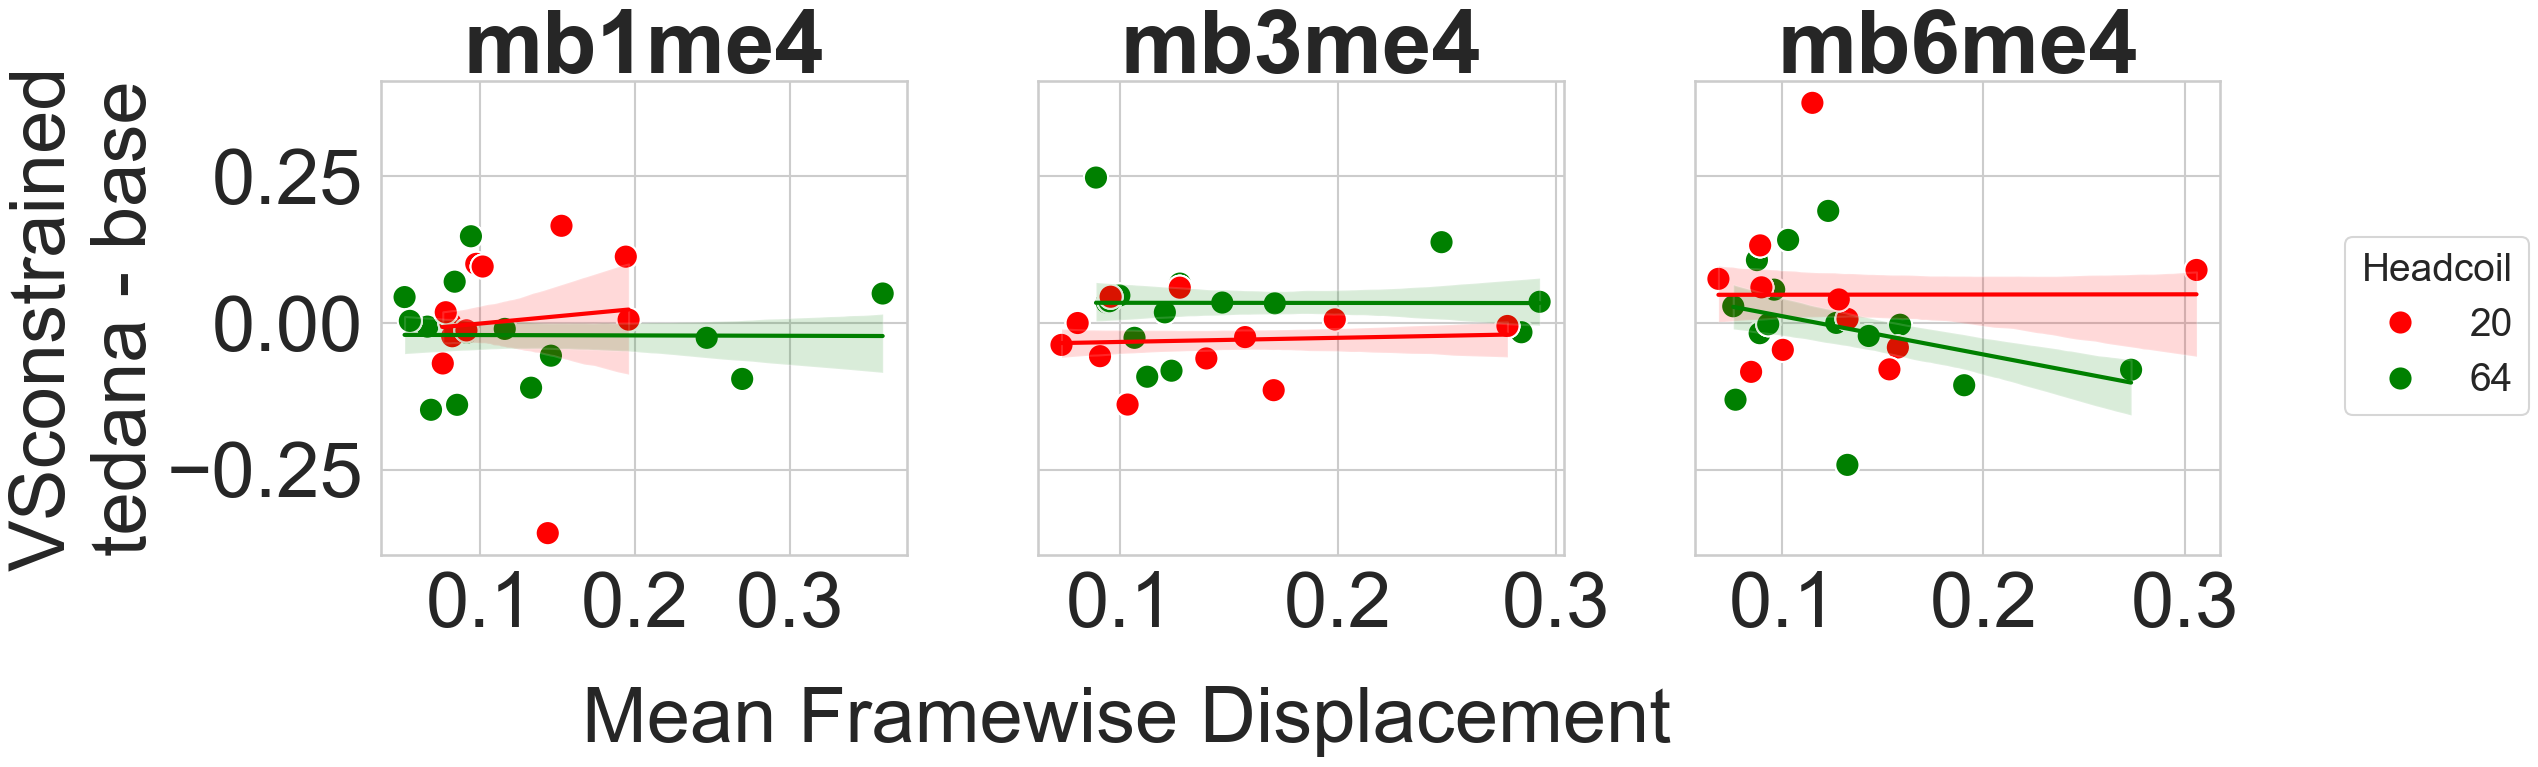

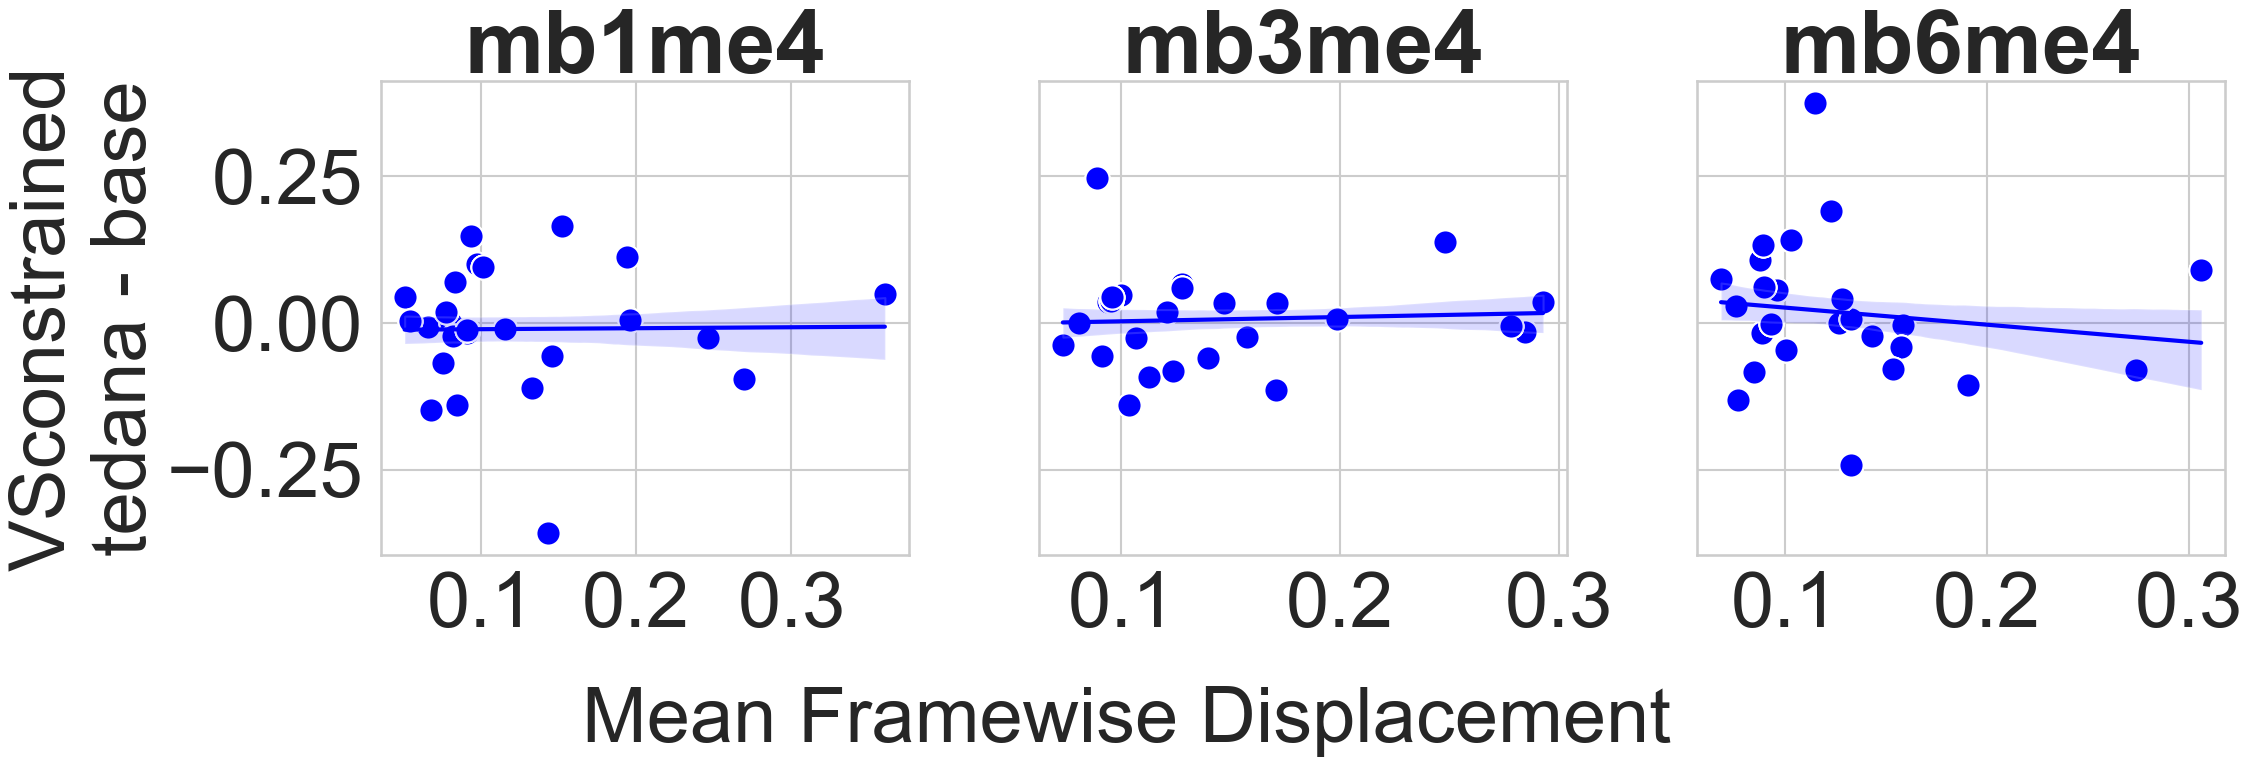

In [33]:
# Figure 8. VSconstrained
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "VSconstrained"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )


Processing files for tedana - base difference: type=act, img=zstat, mask=VMPFC
Found 11361 files in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions
Subjects with data: 40

Number of NaN fd_mean values after merge: 45 out of 345 rows
Data saved to multiecho_tedana_minus_base_act_zstat_VMPFC.csv
Found data for 40 subjects

Sample of the merged data:
  subject  headcoil     acq  tedana_minus_base   fd_mean
0   10017        64  mb1me4          -0.101416  0.065809
1   10017        64  mb1me4          -0.101416  0.065809
2   10017        64  mb1me4          -0.101416  0.065809
3   10017        64  mb1me4          -0.101416  0.065809
4   10024        64  mb1me4           0.027229       NaN

Creating scatter plots...


/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_64769/162252632.py:114: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend_handles = scatter.legend_.legendHandles


Plot saved as 'tedana_minus_base_scatter_act_zstat_VMPFC.png'


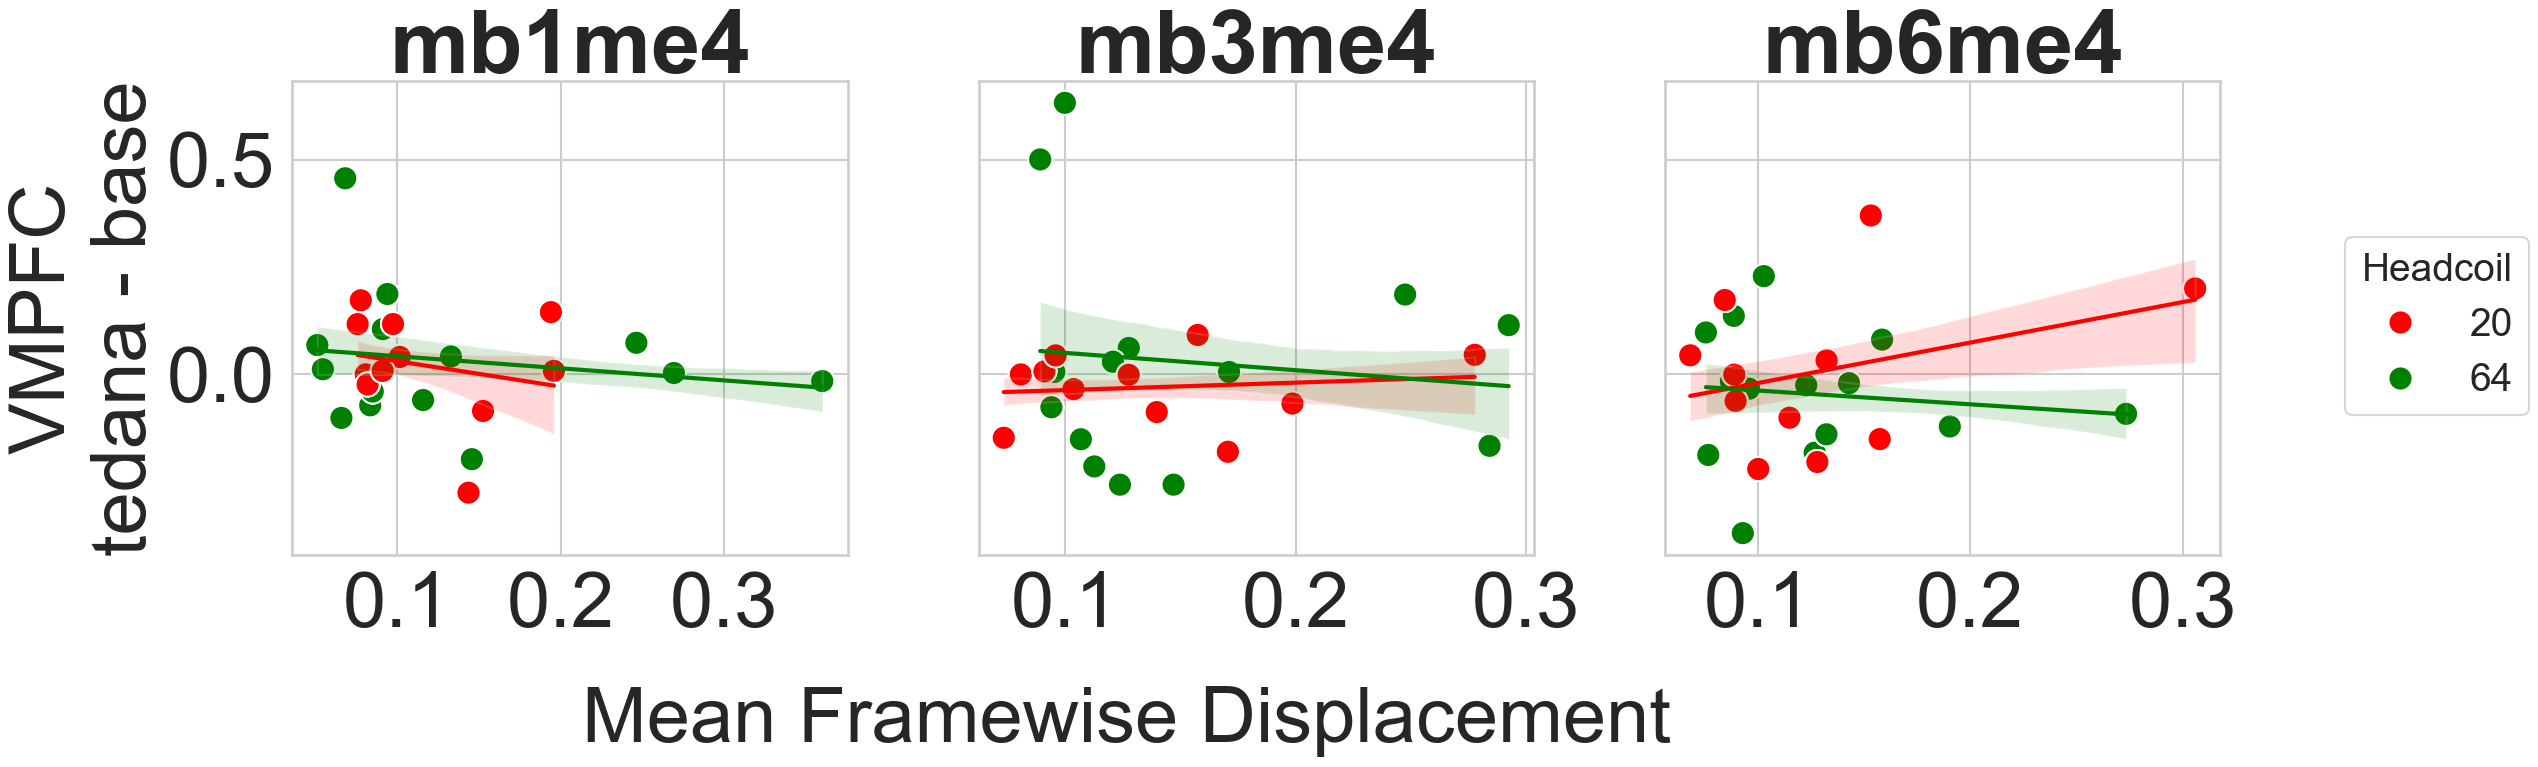

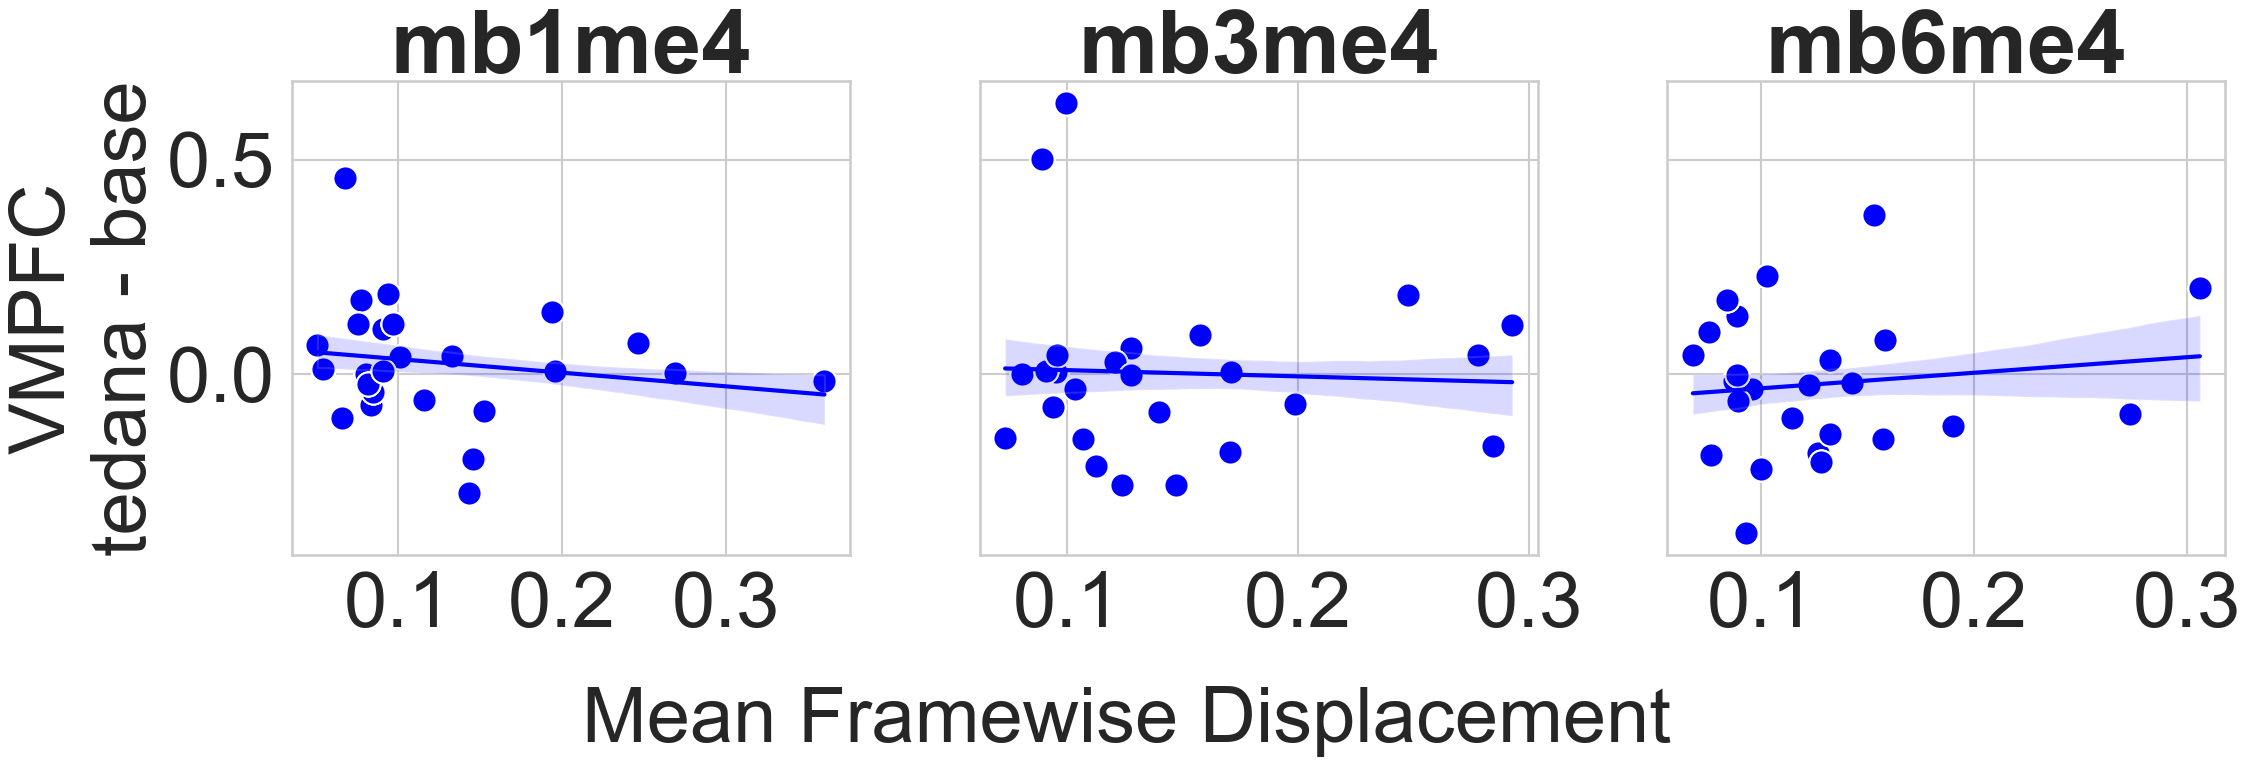

In [35]:
# Figure 8. VMPFC
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "VMPFC"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )


Processing files for tedana - base difference: type=act, img=zstat, mask=rFFA
Found 11361 files in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions
Subjects with data: 40

Number of NaN fd_mean values after merge: 45 out of 345 rows
Data saved to multiecho_tedana_minus_base_act_zstat_rFFA.csv
Found data for 40 subjects

Sample of the merged data:
  subject  headcoil     acq  tedana_minus_base   fd_mean
0   10017        64  mb1me4           0.028894  0.065809
1   10017        64  mb1me4           0.028894  0.065809
2   10017        64  mb1me4           0.028894  0.065809
3   10017        64  mb1me4           0.028894  0.065809
4   10024        64  mb1me4          -0.646562       NaN

Creating scatter plots...


/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_64769/162252632.py:114: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend_handles = scatter.legend_.legendHandles


Plot saved as 'tedana_minus_base_scatter_act_zstat_rFFA.png'


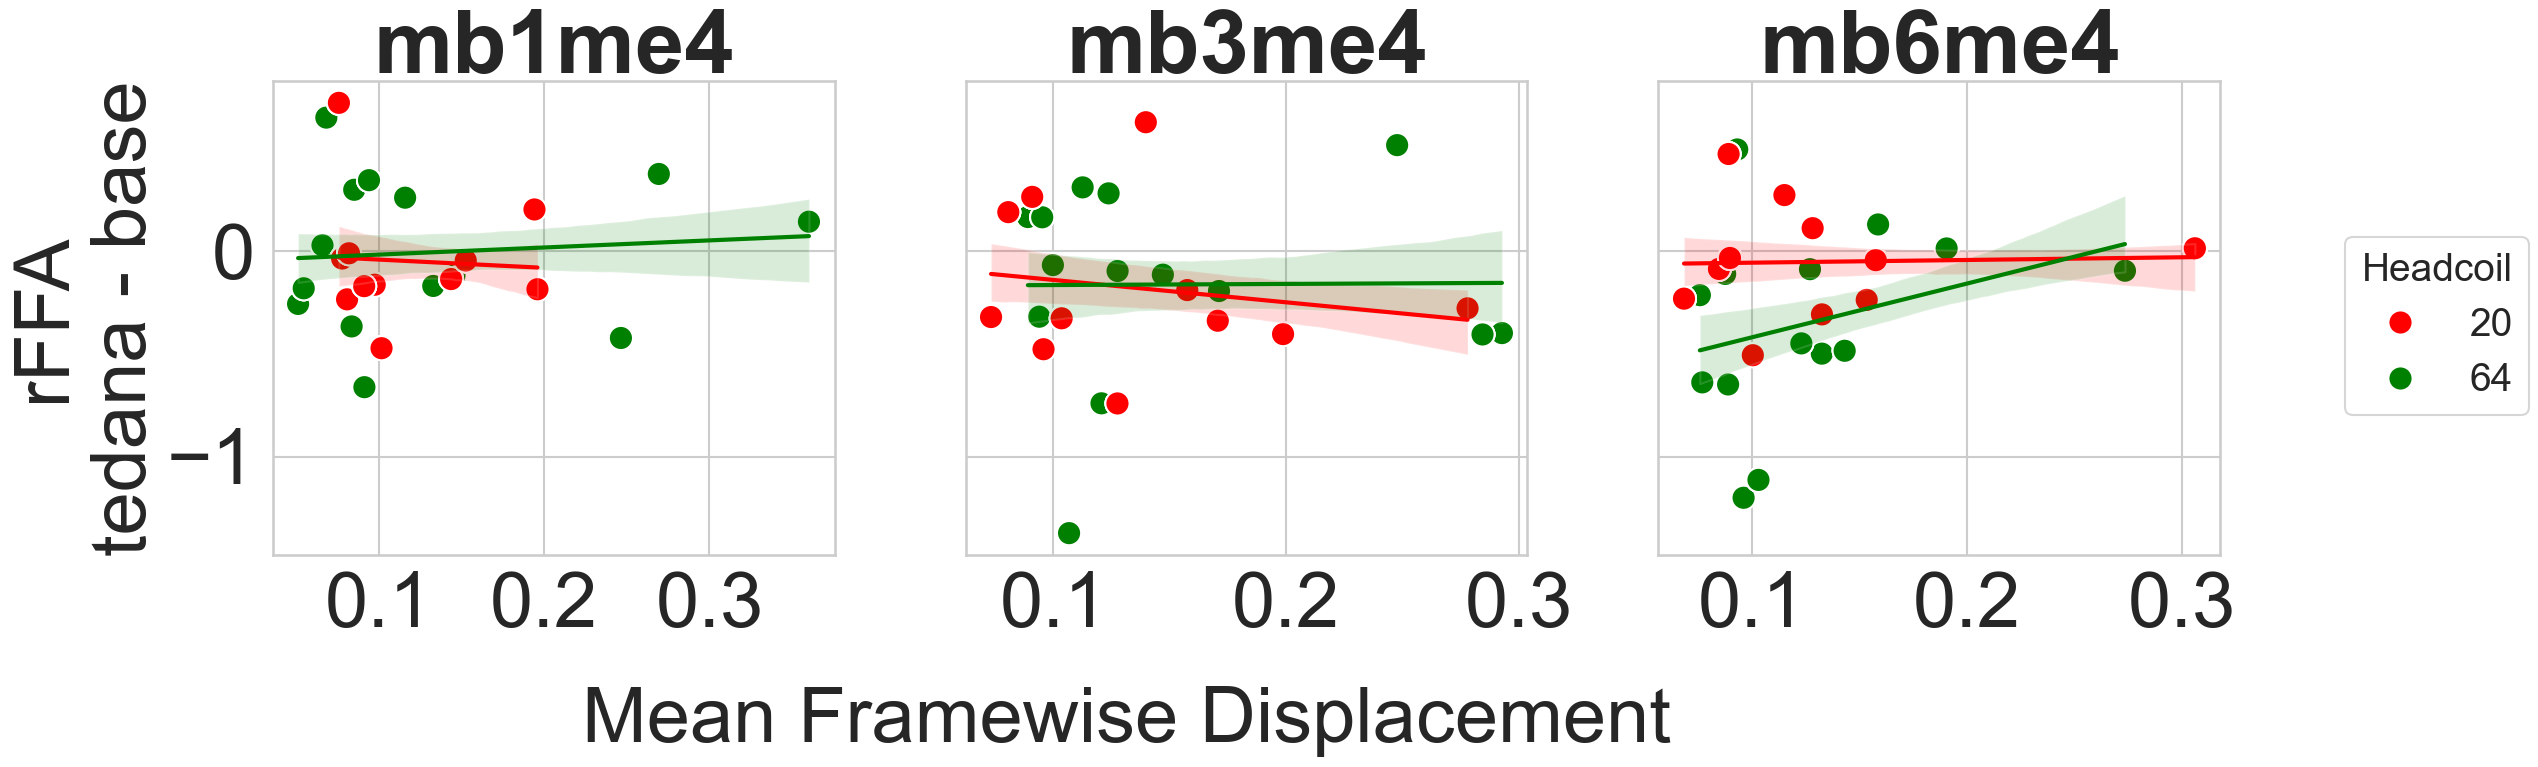

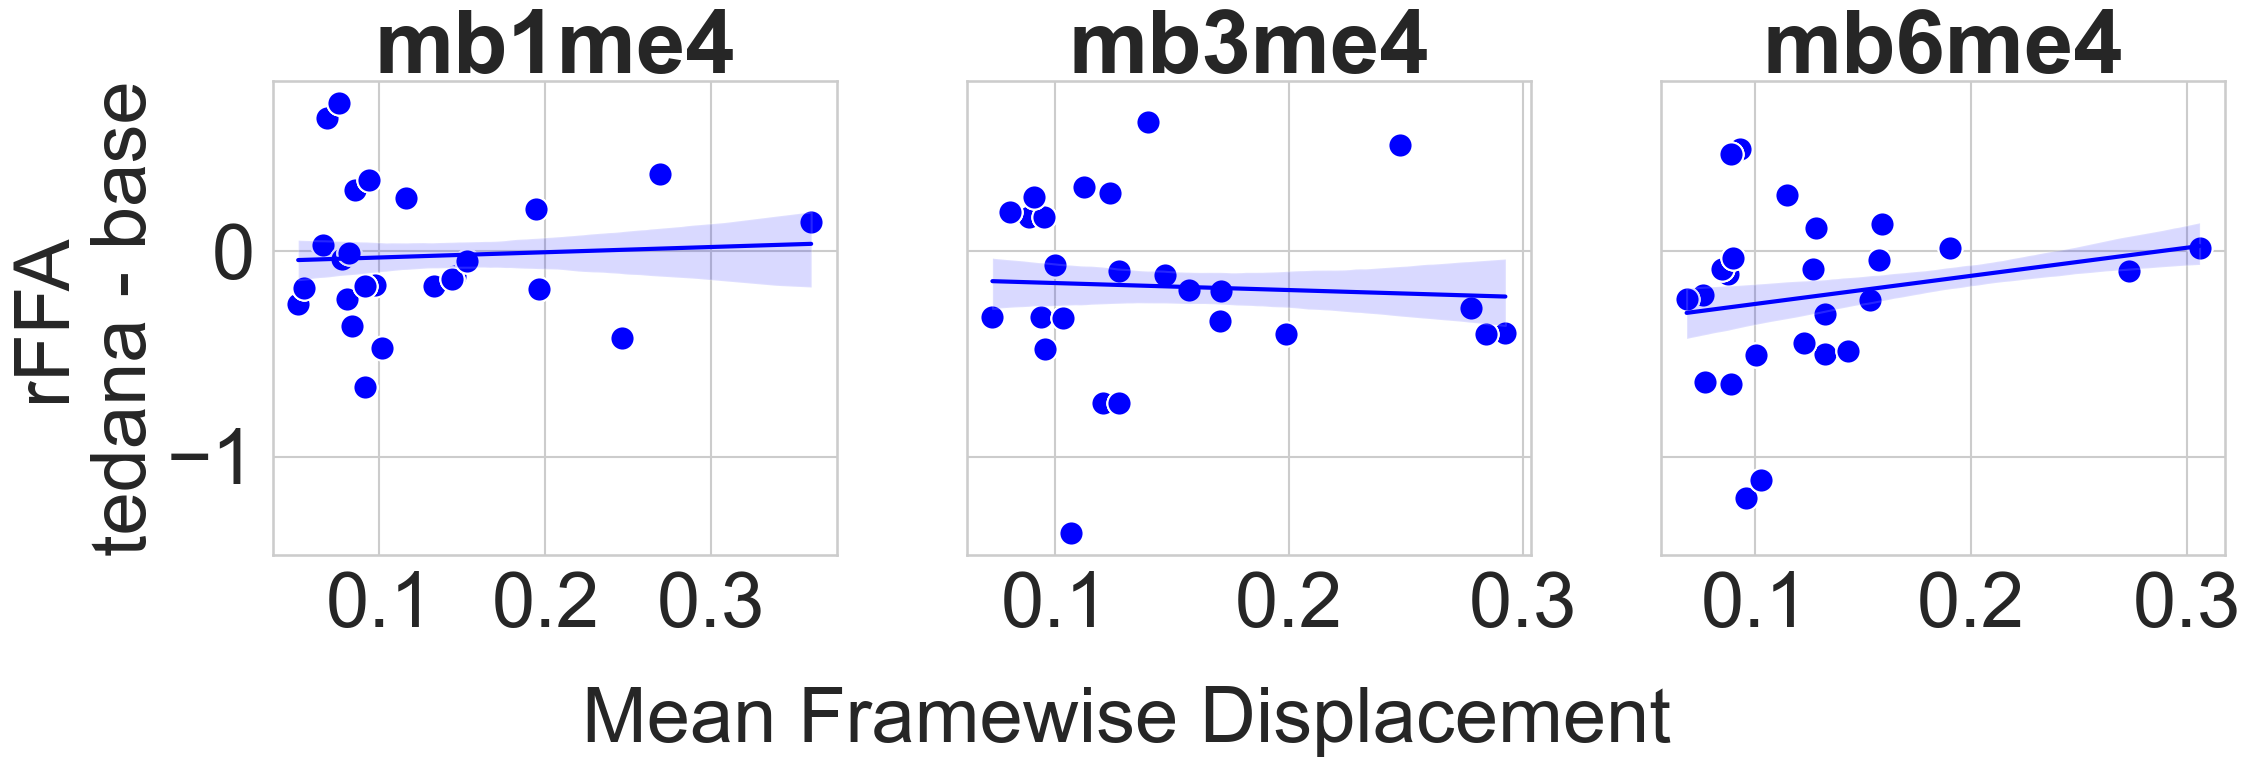

In [37]:
# Figure 8. rFFA
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "rFFA"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )


Processing files for tedana - base difference: type=act, img=zstat, mask=bilateralMotor
Found 11361 files in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions
Subjects with data: 40

Number of NaN fd_mean values after merge: 45 out of 345 rows
Data saved to multiecho_tedana_minus_base_act_zstat_bilateralMotor.csv
Found data for 40 subjects

Sample of the merged data:
  subject  headcoil     acq  tedana_minus_base   fd_mean
0   10017        64  mb1me4           0.486423  0.065809
1   10017        64  mb1me4           0.486423  0.065809
2   10017        64  mb1me4           0.486423  0.065809
3   10017        64  mb1me4           0.486423  0.065809
4   10024        64  mb1me4          -0.389033       NaN

Creating scatter plots...


/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_64769/162252632.py:114: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend_handles = scatter.legend_.legendHandles


Plot saved as 'tedana_minus_base_scatter_act_zstat_bilateralMotor.png'


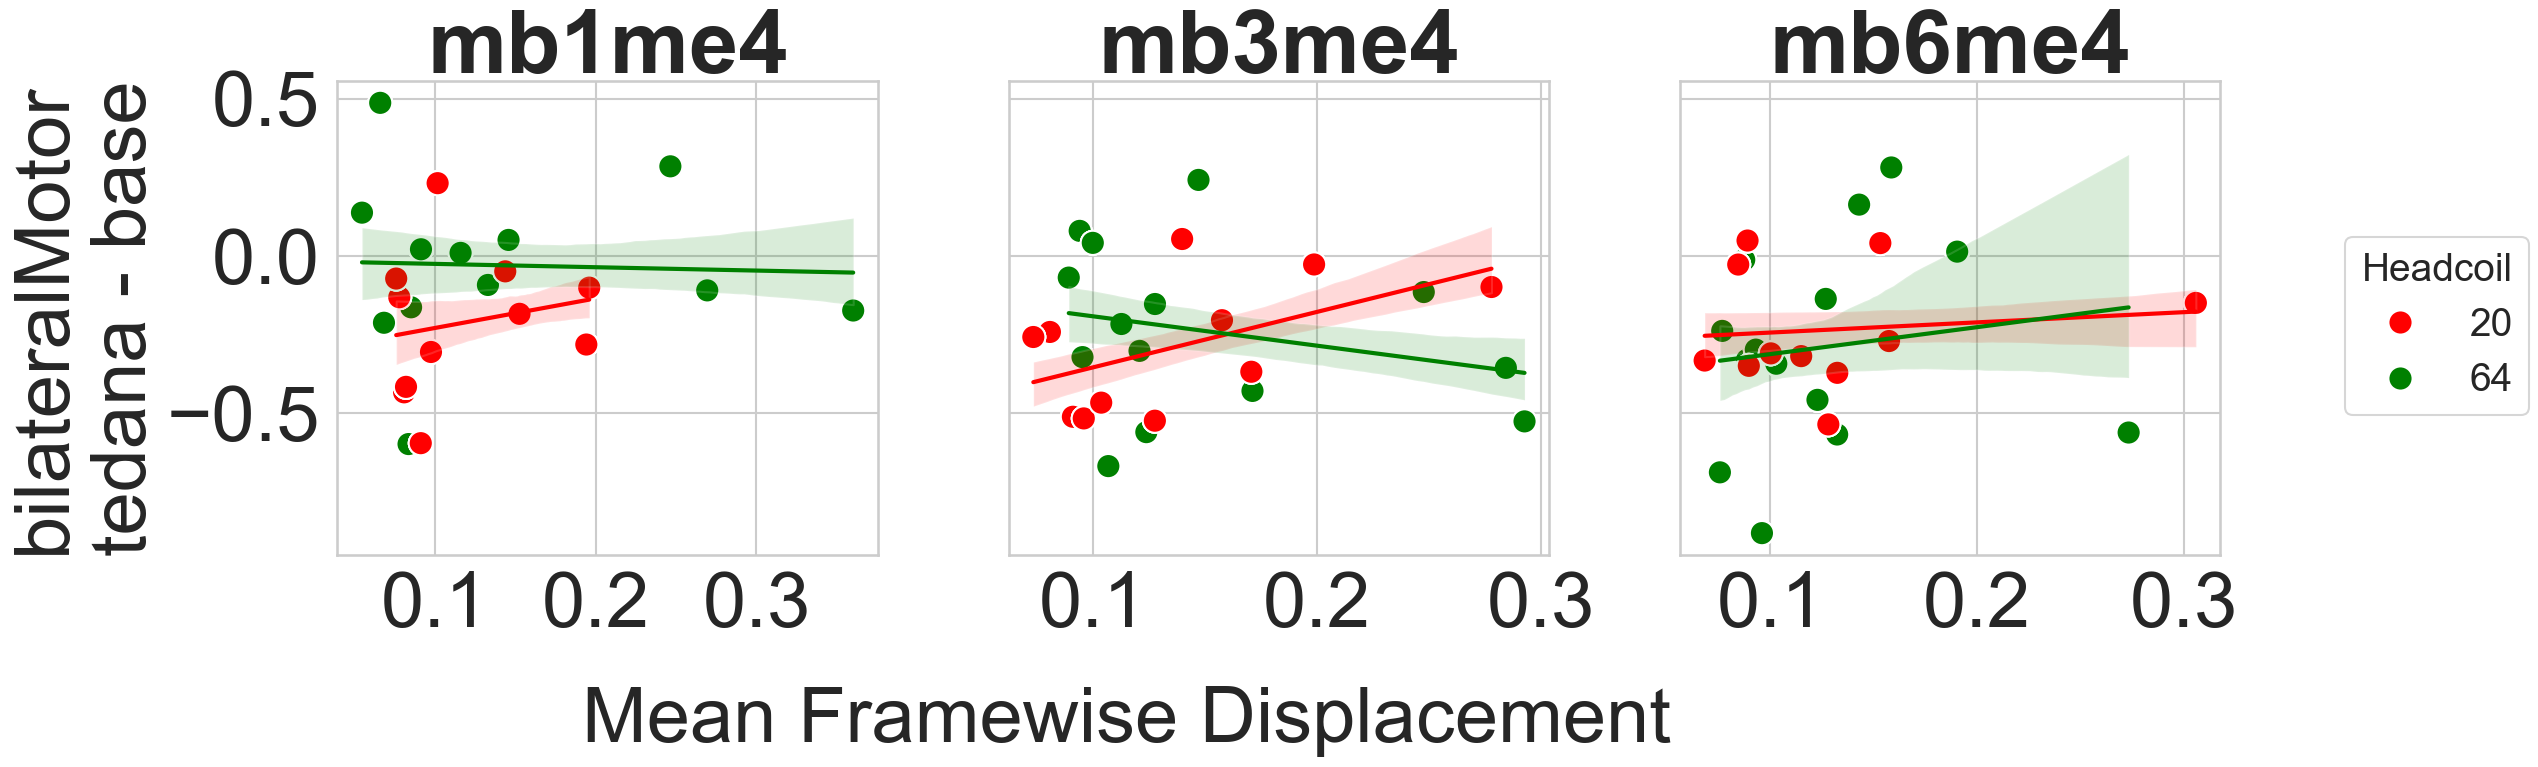

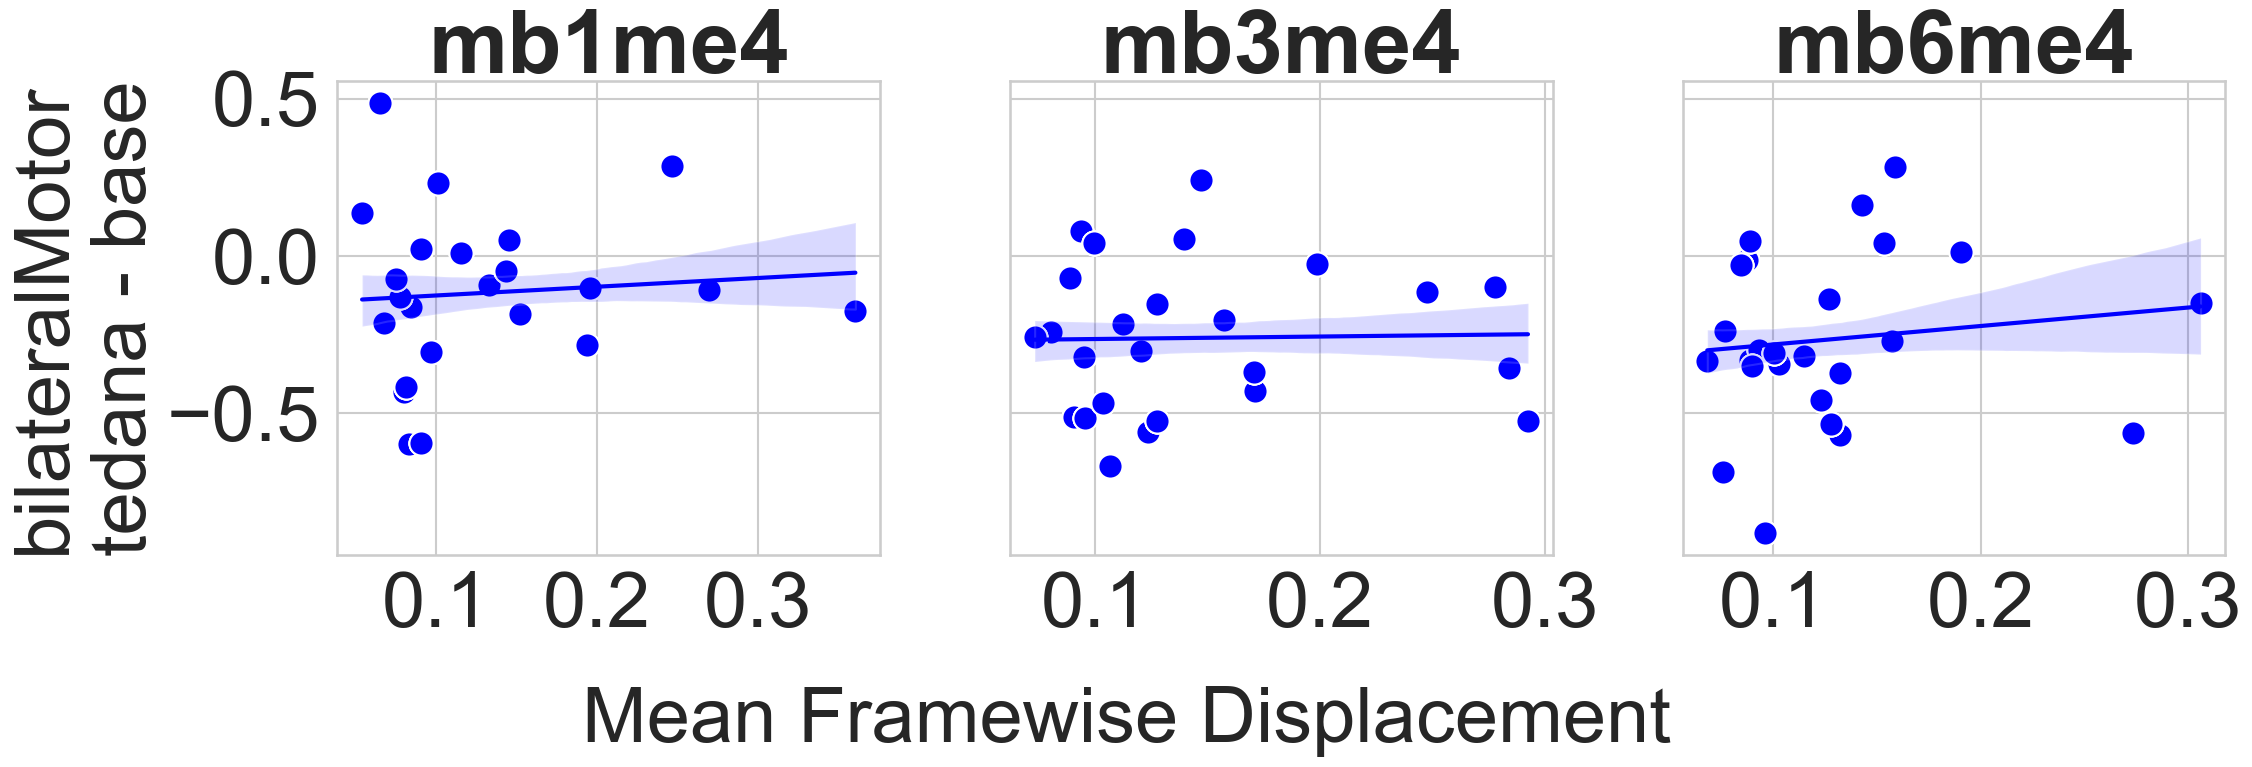

In [39]:
# Figure 8. bilateralMotor
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "bilateralMotor"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )


Processing files for tedana - base difference: type=act, img=zstat, mask=bilateralCerebellum
Found 11361 files in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions
Subjects with data: 40

Number of NaN fd_mean values after merge: 45 out of 345 rows
Data saved to multiecho_tedana_minus_base_act_zstat_bilateralCerebellum.csv
Found data for 40 subjects

Sample of the merged data:
  subject  headcoil     acq  tedana_minus_base   fd_mean
0   10017        64  mb1me4           0.349442  0.065809
1   10017        64  mb1me4           0.349442  0.065809
2   10017        64  mb1me4           0.349442  0.065809
3   10017        64  mb1me4           0.349442  0.065809
4   10024        64  mb1me4          -0.303002       NaN

Creating scatter plots...


/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_64769/162252632.py:114: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend_handles = scatter.legend_.legendHandles


Plot saved as 'tedana_minus_base_scatter_act_zstat_bilateralCerebellum.png'


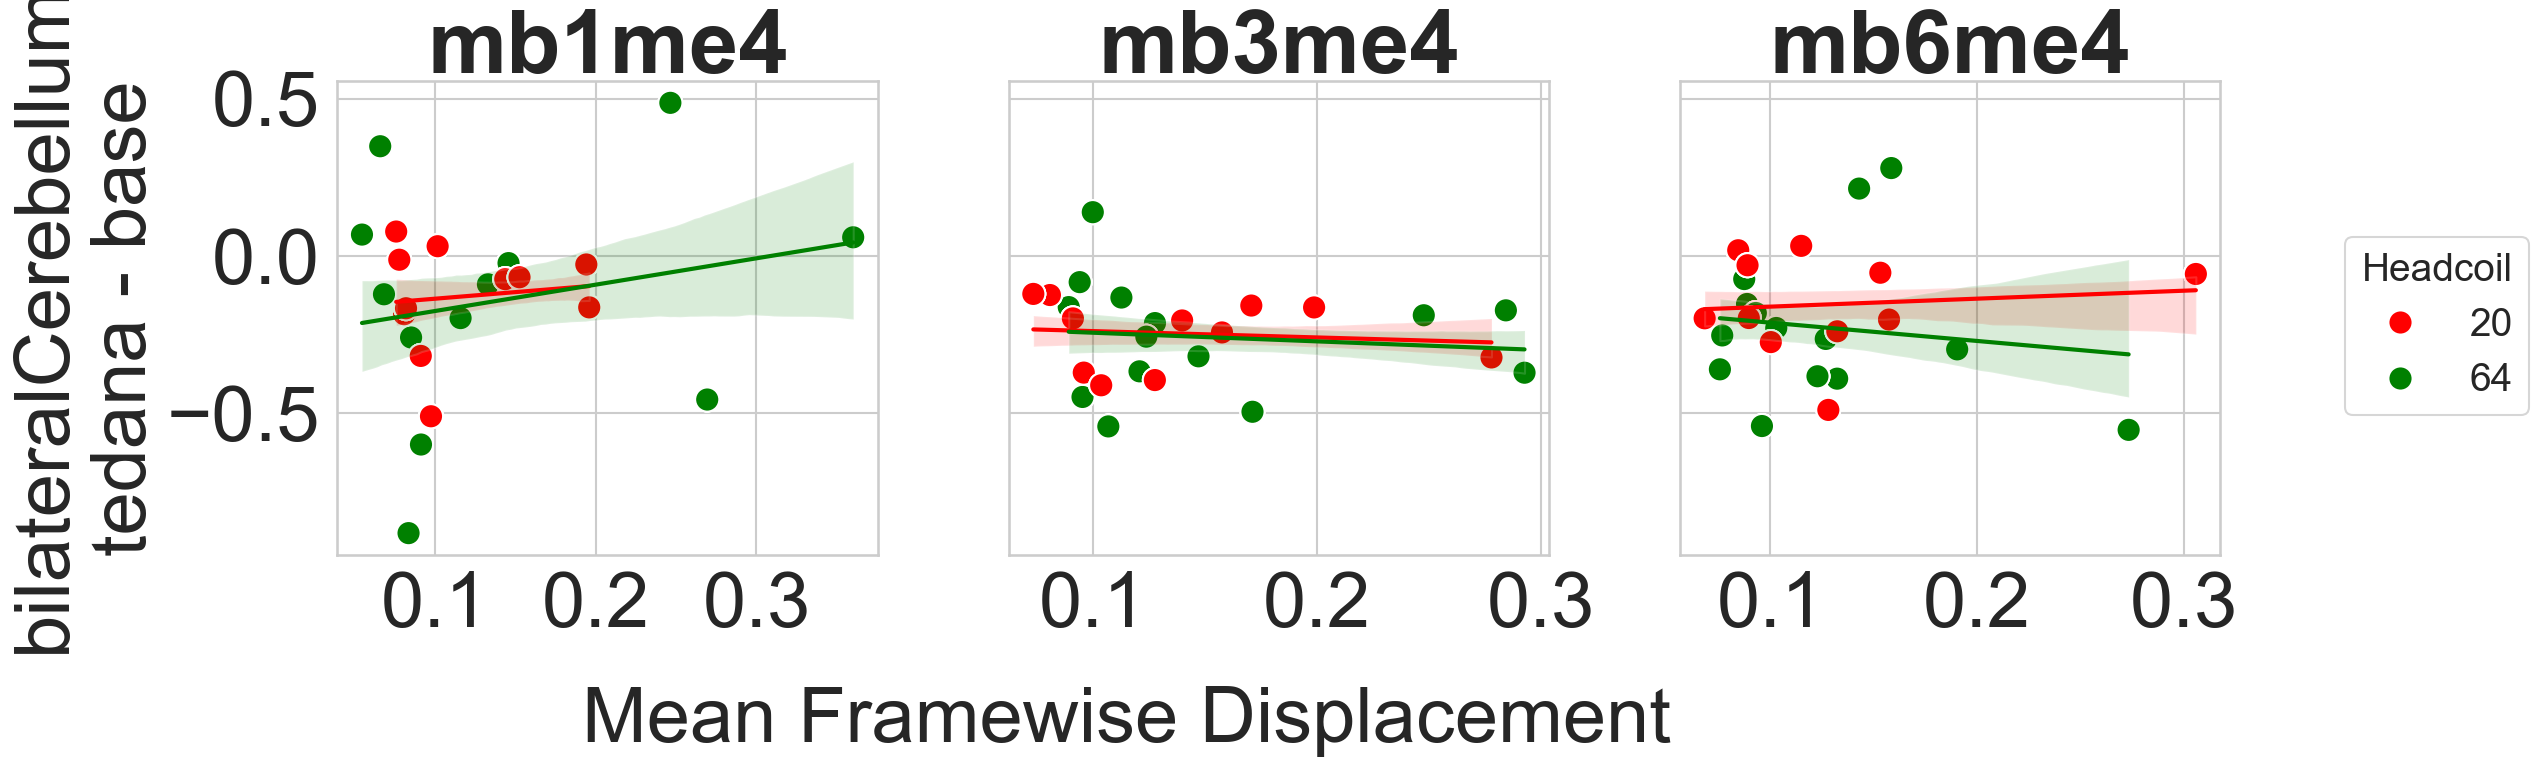

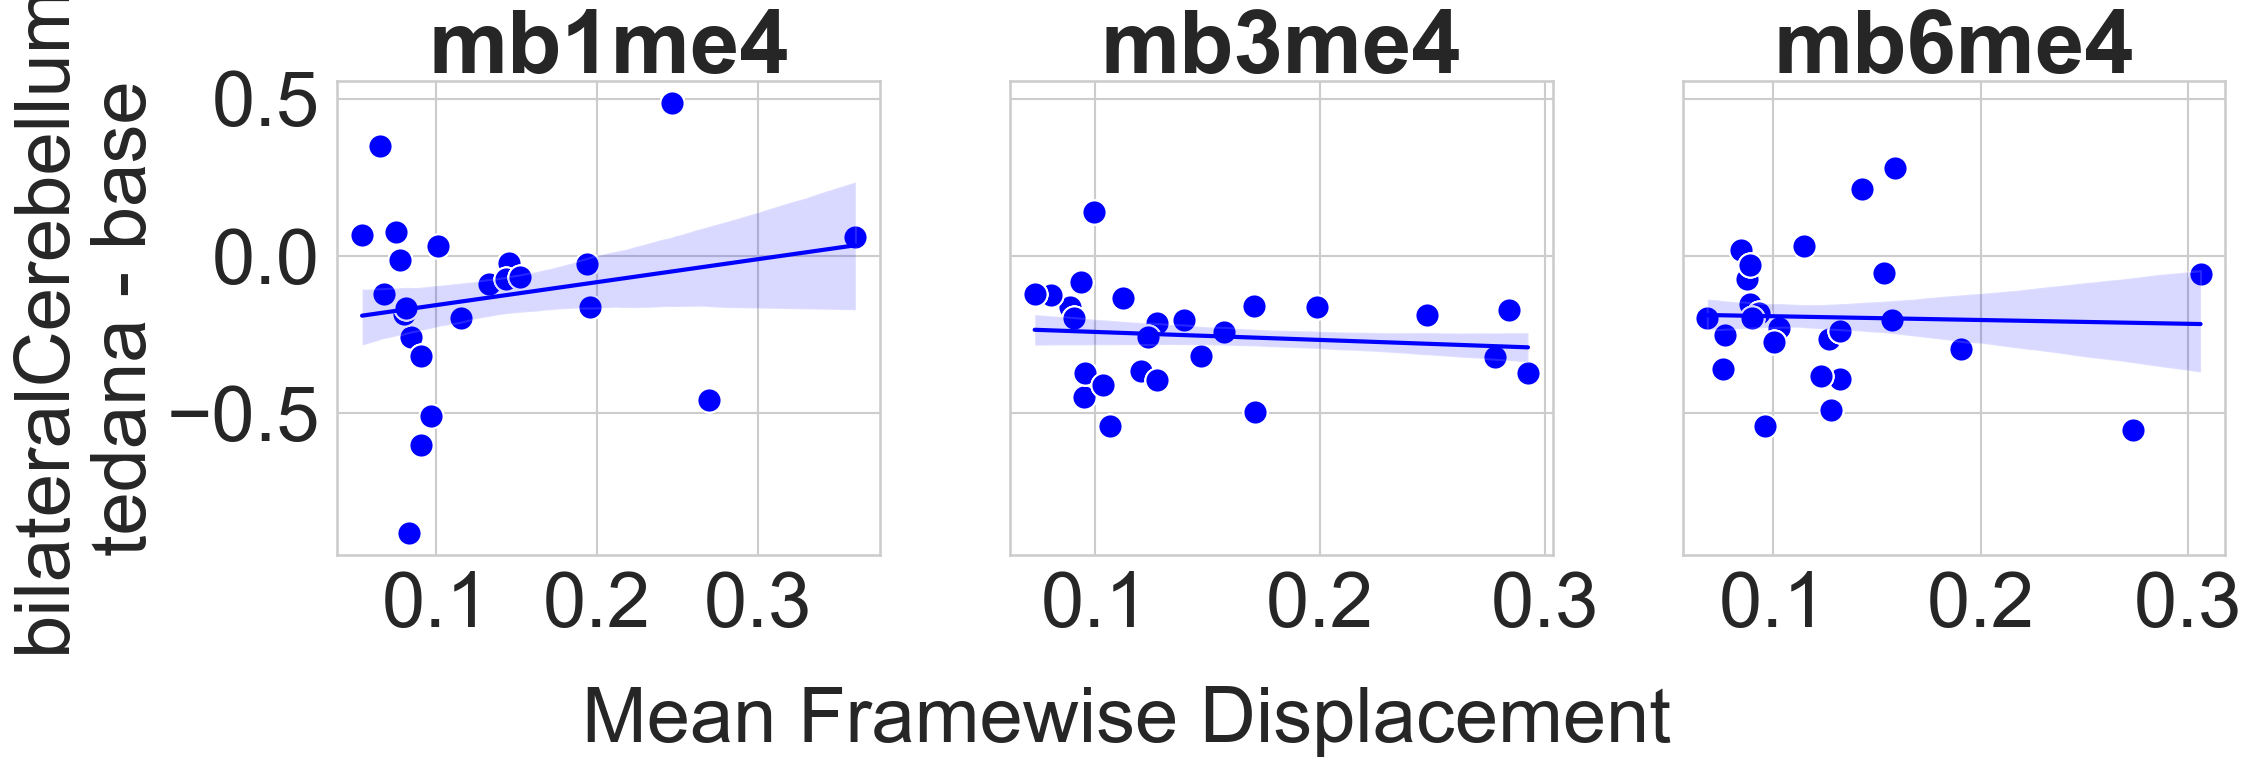

In [41]:
# Figure 8. bilateralCerebellum
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "bilateralCerebellum"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

# Fig 9. Bar Plot Analysis of fMRI Metrics for Specific Subjects

This code chunk defines functions to extract, process, and visualize fMRI metric data (e.g., beta values) from text files for a subset of subjects (those with `sp` in their IDs) across specified multiecho acquisition parameters (e.g., mb1me1, mb3me4). It generates a bar plot summarizing mean values and standard errors for a given region of interest (ROI) and metric, focusing on acquisition effects.

### Key Components
1. **Data Extraction**:
   - `extract_file_data`: 
     - Scans a directory (e.g., `base_dir`) for text files matching a regex pattern (`ts_sub-<ID>_acq_<...>.txt`).
     - Filters files by `type_value` (e.g., `act`), `img_value` (e.g., `beta`), `mask_value` (e.g., `VSconstrained`), `denoise_value` (e.g., `smooth`), and a list of `acq_params`.
     - Extracts float values for subjects with `sp` in their IDs, storing data in a dictionary by subject and acquisition.

2. **Data Structuring**:
   - `create_dataframe`: 
     - Converts the extracted data into a wide-format DataFrame with columns: `subject` and the specified `acq_params`.
     - Sorts by subject ID for consistency.

3. **Data Aggregation**:
   - `prepare_plot_data`: 
     - Computes means and standard errors of the metric for each acquisition parameter.
     - Returns a dictionary with results and the total subject count.

4. **Visualization**:
   - `create_bar_plot`: 
     - Generates a bar plot with lavender bars, showing mean metric values across acquisitions, with error bars (standard errors).
     - Customizes aesthetics: large fonts (e.g., title=48, labels=40), rotated x-tick labels, and dynamic y-axis limits.
   - Y-axis: Labeled with the ROI and metric (e.g., `VSconstrained, beta`); X-axis: Acquisition types.

5. **Execution**:
   - `process_and_visualize`: 
     - Runs the full pipeline: extracts data, creates a DataFrame, prepares plot data, and generates the bar plot.
     - Saves the DataFrame as a CSV and the plot as a PNG with descriptive filenames.

### Inputs
- `base_dir`: Directory containing fMRI text files (e.g., `~/Documents/GitHub/multiecho-pilot/derivatives/extractions`).
- `acq_params`: List of acquisitions (e.g., `["mb1me1", "mb3me4", "mb6me4"]`).
- `type_value`: Analysis type (e.g., `act` for activation).
- `img_value`: Metric to analyze (e.g., `beta`).
- `mask_value`: ROI (e.g., `VSconstrained`).
- `denoise_value`: Denoising method (e.g., `smooth`).

### Outputs
- **DataFrame**: Saved as `multiecho_data_<type>_<img>_<mask>_<denoise>.csv`, with subject IDs and metric values per acquisition.
- **Plot**: Bar plot saved as `multiecho_plots_<type>_<img>_<mask>_<denoise>.png`, showing means and errors across acquisitions.
- **Returns**: Processed DataFrame and matplotlib figure object.

### Notes
- Only processes subjects with `sp` in their IDs (e.g., special pilot subjects), excluding others.
- Handles missing or invalid files by skipping them and reporting errors, with NaNs for unmatched acquisitions.
- Plot design (lavender bars, whitegrid style) is optimized for clarity and publication quality.
- Assumes text files contain a single float value; errors are printed for debugging.

This chunk supports Figure 9 by summarizing fMRI metrics for a specific subject group across acquisition types, providing a visual and tabular representation of data quality or effect sizes.

In [44]:
# Define functions for Figure 9

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

def extract_file_data(base_dir, acq_params, type_value, img_value, mask_value, denoise_value):
    """
    Extracts numerical data from text files matching specified parameters.
    
    Parameters:
    - base_dir: Path to the directory containing text files.
    - acq_params: List of acquisition parameters to include.
    - type_value, img_value, mask_value, denoise_value: Filtering criteria for filenames.
    
    Returns:
    - data_by_subject: Dictionary with subjects as keys and acquisition data as values.
    """
    pattern = re.compile(
        r"ts_sub-(\d+[a-zA-Z]*)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )

    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    matched_files = 0
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' not in sub_id:
                continue
            if (file_type.lower() == type_value.lower() and 
                img.lower() == img_value.lower() and 
                mask.lower() == mask_value.lower() and 
                denoise.lower() == denoise_value.lower() and 
                acq in acq_params):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                    matched_files += 1
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")

    print(f"Total matched files: {matched_files}")
    return data_by_subject

def create_dataframe(data_by_subject, acq_params):
    """
    Converts extracted data into a structured DataFrame.

    Parameters:
    - data_by_subject: Dictionary with extracted numerical values.
    - acq_params: List of acquisition parameters (column order).
    
    Returns:
    - df: DataFrame with subject IDs and extracted values.
    """
    df = pd.DataFrame.from_dict(data_by_subject, orient='index').reset_index()
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    column_order = ['subject'] + acq_params
    df = df[column_order].sort_values('subject')
    
    return df

def prepare_plot_data(df, acq_params):
    """
    Computes means and standard errors for each acquisition parameter.

    Parameters:
    - df: DataFrame containing extracted values.
    - acq_params: List of acquisition parameters.

    Returns:
    - results: Dictionary with mean values, errors, and subject count.
    """
    means = {acq: df[acq].mean() for acq in acq_params}
    errors = {acq: df[acq].sem() for acq in acq_params}
    return {'means': means, 'errors': errors, 'count': len(df)}

def create_bar_plot(plot_data, acq_params, title, y_label):
    """
    Creates a formatted bar plot with error bars.

    Parameters:
    - plot_data: Dictionary with mean values, errors, and subject count.
    - acq_params: List of acquisition parameters.
    - title: Plot title.
    - y_label: Y-axis label.

    Returns:
    - fig: The created matplotlib figure.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.set_context("talk")

    means = [plot_data['means'][acq] for acq in acq_params]
    errors = [plot_data['errors'][acq] for acq in acq_params]
    
    x_positions = np.arange(len(acq_params))
    ax.bar(x_positions, means, color='lavender', yerr=errors, capsize=5, width=0.8)

    ax.set_ylabel(y_label, fontsize=40)
    ax.set_title(title, fontsize=48, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(acq_params, fontsize=32, rotation=45, ha='right')
    ax.set_xlabel('Acquisition', fontsize=40)
    ax.tick_params(axis='both', labelsize=32)

    # Adjust y-axis limits dynamically
    y_min = min([v - e for v, e in zip(means, errors) if not np.isnan(v)])
    y_max = max([v + e for v, e in zip(means, errors) if not np.isnan(v)])
    margin = (y_max - y_min) * 0.1
    ax.set_ylim(y_min - margin, y_max + margin)

    plt.tight_layout()
    return fig

def process_and_visualize(base_dir, acq_params, type_value, img_value, mask_value, denoise_value):
    """
    Full pipeline to extract, process, and visualize data.

    Parameters:
    - base_dir: Path to data files.
    - acq_params: List of acquisition parameters.
    - type_value, img_value, mask_value, denoise_value: Filtering criteria.

    Returns:
    - df: Processed DataFrame.
    - fig: Generated bar plot figure.
    """
    print(f"Processing files with parameters: type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}")
    
    data_by_subject = extract_file_data(base_dir, acq_params, type_value, img_value, mask_value, denoise_value)
    
    if not data_by_subject:
        print("No matching files found.")
        return pd.DataFrame(columns=['subject'] + acq_params), plt.figure()
    
    df = create_dataframe(data_by_subject, acq_params)
    df.to_csv(f"multiecho_data_{type_value}_{img_value}_{mask_value}_{denoise_value}.csv", index=False)

    plot_data = prepare_plot_data(df, acq_params)
    fig = create_bar_plot(plot_data, acq_params, f"sp Subjects (n={plot_data['count']})", f'{mask_value}, {img_value}')

    plot_file = f"multiecho_plots_{type_value}_{img_value}_{mask_value}_{denoise_value}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    return df, fig


Processing files with parameters: type=act, img=beta, mask=VSconstrained, denoise=base
Total matched files: 82


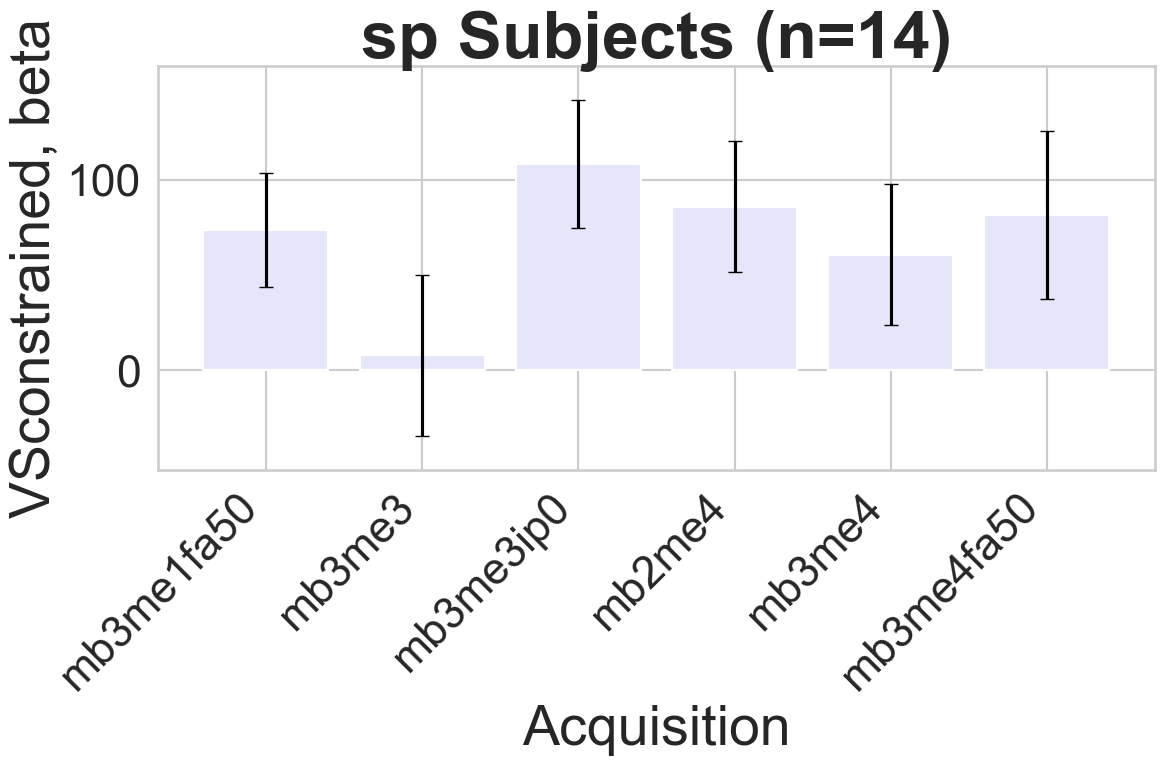

In [46]:
# Figure 9. Beta estimates for activation for each acquisition in VS for ‘SP’ subjects
if __name__ == "__main__":
    BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    ACQ_PARAMS = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]
    
    df, fig = process_and_visualize(
        base_dir=BASE_DIR, 
        acq_params=ACQ_PARAMS, 
        type_value="act", 
        img_value="beta", 
        mask_value="VSconstrained", 
        denoise_value="base"
    )


Processing files with parameters: type=act, img=zstat, mask=VSconstrained, denoise=base
Total matched files: 82


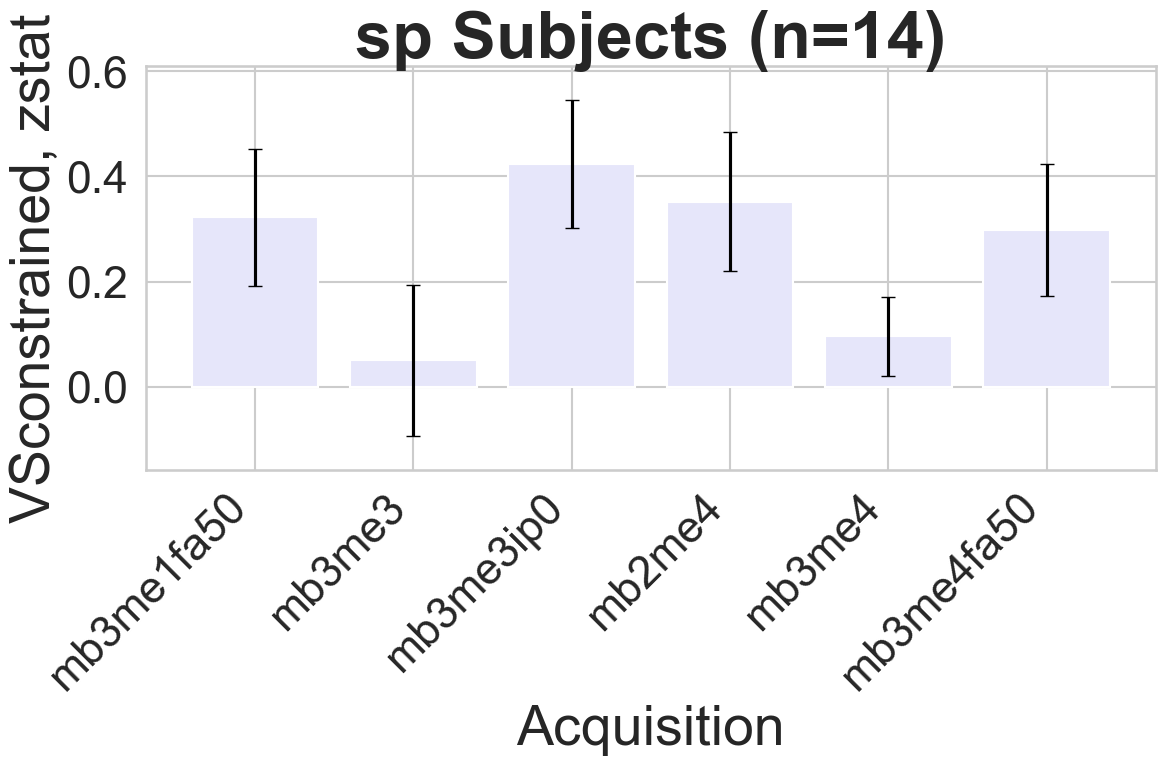

In [48]:
# Supp. Figure 9. zstat for activation for each acquisition in VS for ‘SP’ subjects
if __name__ == "__main__":
    BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    ACQ_PARAMS = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]
    
    df, fig = process_and_visualize(
        base_dir=BASE_DIR, 
        acq_params=ACQ_PARAMS, 
        type_value="act", 
        img_value="zstat", 
        mask_value="VSconstrained", 
        denoise_value="base"
    )